# Segmentation

In this section we try to segment the skin lesions to obtain masks to filter the keypoints obtained in the BoW part.

In [8]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Import necessary packages
import os
import math
import time
import matplotlib
import cv2 as cv
import numpy as np
import numpy.ma as ma
import pandas as pd
import sklearn as sk

from PIL import Image
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow  
from tabulate import tabulate

from scipy import ndimage
from scipy.spatial.distance import dice
from scipy.ndimage import gaussian_filter
from skimage import data, morphology
from skimage.measure import label
from skimage.color import rgb2lab, lab2rgb
from skimage.filters import threshold_multiotsu, threshold_otsu

## Helper Functions

In [6]:
def labEnhance(I):
  '''
    function for Color enhancement 
    param : I         --> Color image
    return : I_retinex --> Color enhanced image 
  '''

  # Textural Information : 
  I_lab = rgb2lab(I)  # RGB to LAB Conversion
  L = I_lab[:,:,0]  # Get Luminance channel

  # Gaussian Filtering : 
  sigma = ndimage.standard_deviation(L)  # Standard Deviation
  LG = gaussian_filter(L, sigma)  # Apply Gaussian Filtering (Smoothing of L Channel)
  I_G = (L*(1 - LG)) / (LG)  # Gaussian Function 

  # Color Information : Activation Function & Retinex Model 
  I_retinex = np.interp(I, (I.min(), I.max()), (0, 255))
  I_G_ = np.interp(I_G, (I_G.min(), I_G.max()), (0, 255))  # Mapping values to 0-255 for comparison
  LG_ = np.interp(LG, (LG.min(), LG.max()), (0, 255))  # Mapping values to 0-255 for comparison
  for x in range(I_G.shape[0]):  # Looping over each pixel
    for y in range(I_G.shape[1]):
      if(I_G_[x,y] > LG_[x,y]):  # In Case of Lesion Pixels, apply MultiScale Retinex model (MSR) for each RGB channel
        I_retinex[x,y,0] = I_retinex[x,y,0] * (I_lab[x,y,0] / LG[x,y]) 
        I_retinex[x,y,1] = I_retinex[x,y,1] * (I_lab[x,y,0] / LG[x,y]) 
        I_retinex[x,y,2] = I_retinex[x,y,2] * (I_lab[x,y,0] / LG[x,y]) 

  return I_retinex

In [5]:
def get_diskMask(Img):
  '''
    Function to detect the colorful disks at the borders of dermoscopy images
    param : Img     --> Color image
    return : I_mask --> Binary Mask containing image artefacts 
  '''

  # ---  Part 1 : Inverse of Red Channel  --------------------------------------
  # Multi-Otsu Thresholding (3 classes)
  thresholds = threshold_multiotsu(255-Img[:,:,2],3)
  regions = np.digitize(255-Img[:,:,2], bins=thresholds)
  I = regions == 2  # Keep the brightest regions
  I = np.interp(I, (I.min(), I.max()), (0, 255))  # Mapping values to 0-255
  Op = cv.morphologyEx(I, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5)))  # Morphological Opening
  Op = np.interp(Op, (Op.min(), Op.max()), (0, 1))  # Mapping values to 0-1
  labels = label(Op)  # Connected components to label segmented regions
  
  # Create a thin and empty rectangle
  th = 5 # Thickness
  blankRect = np.zeros(shape=I.shape, dtype=np.uint8)  # Create a blank matrix
  rect_ = cv.rectangle(blankRect, pt1=(0,0), pt2=(I.shape[1], I.shape[0]), color=(255,0,0), thickness=th)  # Create rectange of thicknss = 5

  intersect = cv.bitwise_and(rect_, Op.astype(np.uint8))  # Apply bitwise_and to keep intersection between rect and segmented image
  Labs = label(intersect == 1)  # Connected components to label intersection regions
  coords = get_coordinates(Labs)  # Get coordinates of these intersection regions
  Im = labels
  for k in range(len(coords)):
    Im = np.where(Im != labels[coords[k][0], coords[k][1]], Im, 255)  # Keep the image, unless it's one of the intersection regions then replace with 0

  Im_ = Im == 255  # keep only the intersection parts of the segmented image
  I_mask1 = np.interp(Im_, (Im_.min(), Im_.max()), (0, 255))

  # ---  Part 2 : Blue Channel  ------------------------------------------------
  # Multi-Otsu Thresholding (3 classes)
  thresholds = threshold_multiotsu(Img[:,:,0],3)
  regions = np.digitize(Img[:,:,0], bins=thresholds)
  I = regions == 2
  I = np.interp(I, (I.min(), I.max()), (0, 255))
  Op = cv.morphologyEx(I, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5)))
  Op = np.interp(Op, (Op.min(), Op.max()), (0, 1))
  labels = label(Op)  # Connected components to label segmented regions
  
  # Create a thin and empty rectangle
  th = 5 # Thickness
  blankRect = np.zeros(shape=I.shape, dtype=np.uint8)  # Create a blank matrix
  rect_ = cv.rectangle(blankRect, pt1=(0,0), pt2=(I.shape[1], I.shape[0]), color=(255,0,0), thickness=th)  # Create rectange of thickness = 5

  intersect = cv.bitwise_and(rect_, Op.astype(np.uint8))  # Apply bitwise_and to keep intersection between rect and segmented image
  Labs = label(intersect == 1)  # Connected components to label intersection regions
  coords = get_coordinates(Labs)  # Get coordinates of these intersection regions
  Im = labels
  for k in range(len(coords)):
    Im = np.where(Im != labels[coords[k][0], coords[k][1]], Im, 255)  # Keep the image, unless it's one of the intersection regions then replace with 0

  Im_ = Im == 255  # keep only the intersection parts of the segmented image
  I_mask2 = np.interp(Im_, (Im_.min(), Im_.max()), (0, 255))

  # ---  Final Mask  -----------------------------------------------------------
  I_m = I_mask1 + I_mask2  # Add both masks to get all artefacts
  I_m = I_m >= 255
  Im_op = np.interp(I_m, (I_m.min(), I_m.max()), (0, 255))
  I_mask =  cv.morphologyEx(Im_op, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE,(9,9)))  # Morphological closing

  return I_mask

In [4]:
def get_segmentation(I):
  '''
  Function to perform segmentation
    param : I      --> Color image
    return : Im_seg --> Segmented image 
  '''

  Ie = labEnhance(I)  # Get the color-enhanced version of the image
  
  # Alternating Sequential Filtering (ASF) :
  kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(15,15))
  opening =  cv.morphologyEx(Ie[:,:,0], cv.MORPH_OPEN, kernel)  # Apply ASF on Blue channel only
  ASF =  cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel)
  ASF = np.interp(ASF, (ASF.min(), ASF.max()), (0, 255))  # Mapping values to 0-255

  mask = get_diskMask(Ie)  # Get the Artefacts' mask
  m = 255*np.ones(Ie.shape)  # Create white image

  if(mask.all() == m.all()):  # If the mask is empty, the whole unmasked image is returned
      masked_ = 255-ASF  # Use the inverse to make the lesion parts the brightest
      masked = masked_
  else:  # If the mask is not empty 
    mask_ = (np.interp(mask, (mask.min(), mask.max()),(0,1))).astype(np.uint8)
    masked_ = ma.masked_array(255-ASF,mask_)  # Mask the inverse of ASF (for lesion parts to be bright)
    masked = masked_.compressed() # returns the non-masked values as 1D array 
  
  #  ------  OTSU Thesholding  ------  
  thresholds = (threshold_multiotsu((masked),2)).astype(np.uint8)  # Apply binary OTSU thresholding
  regions = np.digitize(masked_, bins=thresholds)
  Im_seg = np.interp(regions, (regions.min(), regions.max()), (0, 255))  # Mapping values to 0-255
  
  # Apply morphological Opening to remove noise/small parts
  Im_seg =  cv.morphologyEx(Im_seg, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(9,9)))
  
  return Im_seg
# ---------------

In [3]:
def get_coordinates(Labs):  # Get coordinates of labelled regions
  '''param : Labs --> Labelled regions
    return : coor --> Coordinates of the labelled regions'''
  coor = []
  for i in range(Labs.max()):
    indices = np.where(Labs==[i+1])
    coordinates = (indices[0], indices[1])
    coor.append([indices[0][0], indices[1][0]])
  return coor


def distance_points(x1,y1,x2,y2):
  '''param : x1,y1,x2,y2 --> Coordinates of 2 points
    return : dist        --> Mathematical distance between the 2 points'''

  dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
  return dist 

In [2]:
# Function to read the preprocessed images 
def read_img_prepro(img_id, set_):
    cat =  img_id[0:3]
    path = f"/content/drive/MyDrive/CAD_Dataset/Challenge2/preprocessed/{set_}/{cat}/{img_id}.jpg"
    img = cv.imread(path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img_rgb

## Segment and Save Images 

In [9]:
train_csv = '/content/drive/MyDrive/CAD_Dataset/Challenge2/train.csv'
val_csv = '/content/drive/MyDrive/CAD_Dataset/Challenge2/val.csv'

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)

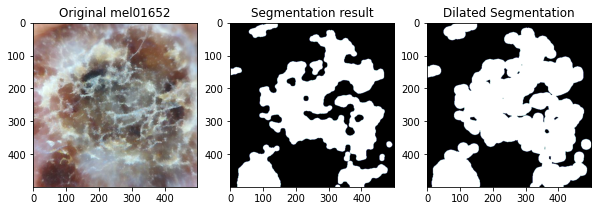

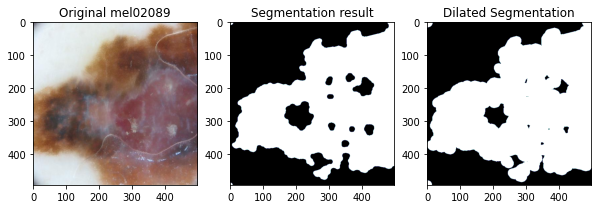

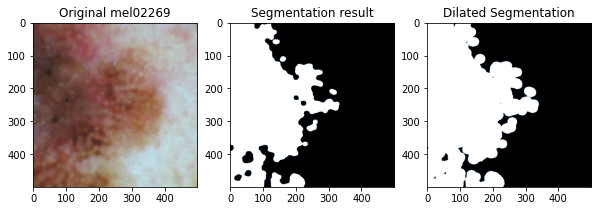

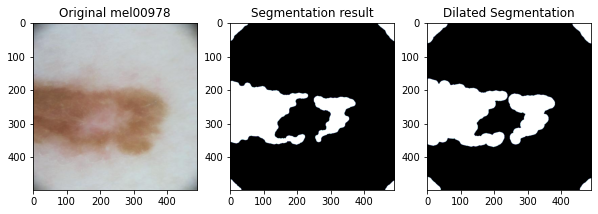

In [10]:
# Show some examples
for i, row in train_df.iterrows(): 
      if i > 3: 
        break
      fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))
      
      img_id = row['image_id']
      image = read_img_prepro(img_id, 'train')
          
      
      # Plotting the original image
      ax[0].imshow(image)
      ax[0].set_title(f'Original {img_id}')
      ax[0].axis('on')
      
      # Segmentation
      Seg = get_segmentation(image)
      
      ax[1].imshow(Seg, cmap='bone')
      ax[1].set_title('Segmentation result')
      ax[1].axis('on')
    
      # Morphological Dilation       
      Dilated = cv.morphologyEx(Seg, cv.MORPH_DILATE, cv.getStructuringElement(cv.MORPH_ELLIPSE,(15,15)))
      ax[2].imshow(Dilated, cmap='bone')
      ax[2].set_title('Dilated Segmentation')
      ax[2].axis('on')

      plt.subplots_adjust()
      plt.show()

In [ ]:
# Segment and save all images 
for i, row in train_df.iterrows():       
    img_id = row['image_id']
    image = read_img_prepro(img_id, 'train')

    # Segmentation
    Seg = get_segmentation(image)
      
    # Morphological Dilation       
    Dilated = cv.morphologyEx(Seg, cv.MORPH_DILATE, cv.getStructuringElement(cv.MORPH_ELLIPSE,(15,15)))

    # Save Segmented Images's Mask in 'Dataset_2/AIA/Masks_/Train/' Folder
    cv.imwrite(f'/content/drive/MyDrive/CAD_Dataset/Challenge2/segmentation/train/{img_id}.png', Dilated)

# BoW Classification

## Importing Libraries

In [1]:
import argparse
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
from matplotlib import pyplot as plt
import pickle
import time

################################## MACHINE LEARNING  ###########################################
import sklearn as sk
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, balanced_accuracy_score 
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, SelectFromModel

################################## models  ###########################################
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier, VotingClassifier
from sklearn import linear_model
import xgboost as xgb

# ########################## Sampling ############################à
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Helper Functions

### Reading Data

In [2]:
# function to get a list with file names in a given directory
def get_files(path):
    images = []
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            images.append(os.path.join(path, os.path.join(folder, file)))
    
    return images

In [3]:
# Function to read an image using its path in RGB color space using openCV
def read_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

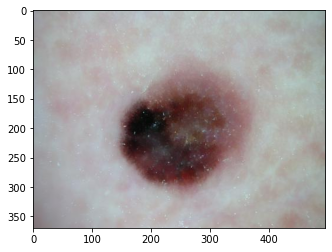

In [16]:
# example image 
img = read_image("/content/drive/MyDrive/CAD_Dataset/Challenge2/preprocessed/val/mel/mel02718.jpg")
plt.imshow(img)

### Feature extraction

In [17]:
# functopn to detect keypoints and extracts keypoint descriptors using a given detector 
def get_descriptors(detector, img, step_size):
    # Dense keypoints every step_size 
    kp1 = [cv2.KeyPoint(x, y, step_size) for y in range(0, img.shape[0], step_size)
          for x in range(0, img.shape[1], step_size)]
    # Keypoints detected by the descriptor 
    kp2 = list(detector.detect(img, None))
    kp = kp1 + kp2
    # compute keypoint descriptors 
    k, des = detector.compute(img, kp)
    return kp, des

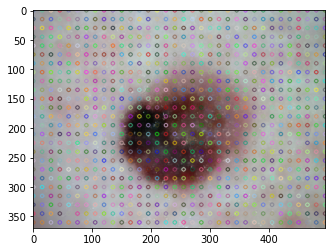

In [23]:
# Dense descriptors 
kp1 = [cv2.KeyPoint(x, y, 15) for y in range(0, img.shape[0], 15)
  for x in range(0, img.shape[1], 15)]
img2 = np.zeros_like(img)
img2 =cv2.drawKeypoints(img, kp1, img2)
plt.imshow(img2)

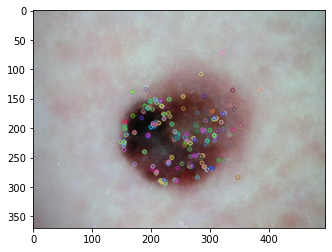

In [24]:
# Keypoints detected by the descriptor 
orb = cv2.ORB_create()
kp2 = list(orb.detect(img, None))
img2 = np.zeros_like(img)
img2 =cv2.drawKeypoints(img, kp2, img2)
plt.imshow(img2)

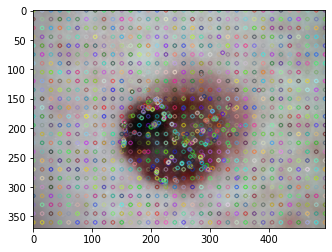

In [25]:
# All keypoints 
kp = kp1 + kp2
img2 = np.zeros_like(img)
img2 =cv2.drawKeypoints(img, kp, img2)
plt.imshow(img2)

In [21]:
# Function to filter the keypoints detected to keep only the ones inside the lesion
def filter_descriptors(kp, des, mask):
    good_kp = []  # List of "good keypoint"
    good_des = []  # List of "good descriptors"

    # Iterate over all keypoints and descriptors and the good ones to a new list. 
    # There is no possibility to mark them unnecessary.
    for k, d in zip(kp, des):
        x, y = k.pt  # Each keypoint as an x, y tuple  
        
        if mask[int(y), int(x)] != 0:
            good_kp.append(k)   # Append keypoint to a list of "good keypoint".
            good_des.append(d)  # Append descriptor to a list of "good descriptors".
            
    if len(good_des) < 10: # if the number of descriptors left is not enough return all descriptors of the image
        good_des = des
        good_kp = kp

    return good_kp, good_des

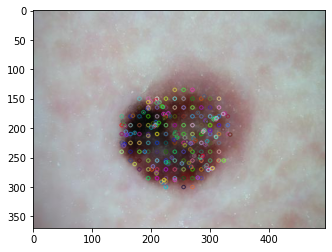

In [30]:
# Example with segmentation
mask = cv2.imread('/content/drive/MyDrive/CAD_Dataset/Challenge2/segmentation/val/mel02718.png')
mask  = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
good_kp, good_des = filter_descriptors(kp, des, mask)
img2 = np.zeros_like(img)
img2 =cv2.drawKeypoints(img, good_kp, img2)
plt.imshow(img2)

In [31]:
# function to convert descriptor list to a numpy ndarray
def vstack_descriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))
    return descriptors

In [32]:
# function to cluster descriptors to no_clusters groups using the kmeans algorithm 
def cluster_descriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters=no_clusters).fit(descriptors)
    return kmeans

In [33]:
# function to extract features by assigning each descriptor in each image to the closest cluster 
def extract_features(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)]) # initialize the features array to zeros
    for i in range(image_count): # iterate for each image 
        for j in range(len(descriptor_list[i])): # iterate for each descriptor in the image
            feature = descriptor_list[i][j] # get the descriptor
            feature = feature.reshape(1, feature.shape[0])
            idx = kmeans.predict(feature) # find the closest cluster (word) to the descriptor
            im_features[i][idx] += 1 # increment the counter of the word by 1 
    return im_features

In [34]:
# Function to normalize the features to 0 mean and 1 std
def normalize_features(scale, features):
    return scale.transform(features)

In [35]:
# function to plot the histogram of words 
def plot_histogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

In [37]:
# Full pipeline of feature extraction  
def extract_features_no_mask(path, no_clusters, detector_type='sift'):
    # find the image paths 
    images = get_files(path)
    print("Train images path detected.")
    
    # initialize the detector 
    if detector_type == 'sift':
        detector = cv2.SIFT_create() 
    elif detector_type == 'orb':
        detector = cv2.ORB_create()
    elif detector_type == 'brisk':
        detector = cv2.BRISK_create()
        
    else: 
        print('Detector not implemented')
        return

    descriptor_list = []
    train_labels = []
    image_count = len(images)
    
    # Read the images and detect the descriptors in each image
    for j, img_path in enumerate(images):
        if "mel" in img_path:
            class_index = 0
        elif "bcc" in img_path:
            class_index = 1
        else:
            class_index = 2
        print(j)
        train_labels.append(class_index)
        img = read_image(img_path)
        kp, des = get_descriptors(detector, img, 15)
        descriptor_list.append(des)

    train_labels = np.array(train_labels)
    descriptors = vstack_descriptors(descriptor_list)
    
    print("Descriptors vstacked.")
    # apply kmeans clustering to the descriptor 
    kmeans = cluster_descriptors(descriptors, no_clusters)
    print("Descriptors clustered.")
    # Extract the features 
    im_features = extract_features(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")
    # Normalize features 
    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")
    # plot histogram of the complete vocabulary 
    plot_histogram(im_features, no_clusters)
    print("Features histogram plotted.")

    return train_labels, kmeans, scale, im_features

In [36]:
# Extract features inside a region of interest only 
def extract_features_with_mask(path, no_clusters, partition):
    images = get_files(True, path)
    print("Train images path detected.")
    sift = cv2.SIFT_create()

    descriptor_list = []
    train_labels = []
    ids = []
    image_count = 0
    
    for j, img_path in enumerate(images):
        
        mask_id = img_path[-12:-4]
        mask_path = f"/content/drive/MyDrive/CAD_Dataset/Challenge2/segmentation/{partition}/{mask_id}.png"
        

        if "mel" in img_path:
            class_index = 0
        elif "bcc" in img_path:
            class_index = 1
        else:
            class_index = 2
        print(j)
        
        img = read_image(img_path)
        mask = cv2.imread(mask_path)
        mask  = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        kp, des = get_descriptors(sift, img, 15)
        good_kp, good_des = filter_descriptors(kp, des, mask)
        if good_des is not None:
            image_count +=1
            descriptor_list.append(good_des)
            train_labels.append(class_index)
            ids.append(mask_id)
    
    train_labels = np.array(train_labels)
    descriptors = vstack_descriptors(descriptor_list)
    
    print("Descriptors vstacked.")

    kmeans = cluster_descriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extract_features(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plot_histogram(im_features, no_clusters)
    print("Features histogram plotted.")

    return train_labels, kmeans, scale, im_features, ids

### Testing

- Feature extraction

In [39]:
def extract_test_features(path, kmeans, scale, no_clusters, detector_type):
    images = get_files(path)
    print("Test images path detected.")
    if detector_type == 'sift':
        detector = cv2.SIFT_create()
    elif detector_type == 'orb':
        detector = cv2.ORB_create()
    elif detector_type == 'brisk':
        detector = cv2.BRISK_create()
        
    else: 
        print('Descriptor not implemented')
        return

    descriptor_list = []
    test_labels = []
    test_ids = []
    image_count = len(images)
    print(f'Total images:{image_count}')   
    c=0
    for j, img_path in enumerate(images):

        if "mel" in img_path:
            class_index = 0
        elif "bcc" in img_path:
            class_index = 1
        else:
            class_index = 2
        print(img_path)
        
        img = read_image(img_path)
        kp, des = get_descriptors(detector, img, 15)
        if des is not None:
            c += 1
            test_ids.append(img_path[-12:-4])
            test_labels.append(class_index)
            descriptor_list.append(des)


    test_labels = np.array(test_labels)

    test_features = extract_features(kmeans, descriptor_list, c, no_clusters)
    print("Images features extracted.")
       
    test_features = scale.transform(test_features)
    return test_features, test_labels, test_ids


In [41]:
def extract_test_features_with_mask(path, kmeans, scale, no_clusters):
    images = get_files(True, path)
    print("Test images path detected.")
    sift = cv2.SIFT_create()

    descriptor_list = []
    test_labels = []
    ids = []
    c = 0
    for j, img_path in enumerate(images):
        
        mask_id = img_path[-12:-4]
        mask_path = f"/content/drive/MyDrive/CAD_Dataset/Challenge2/segmentation/test/{mask_id}.png"

        if "mel" in img_path:
            class_index = 0
        elif "bcc" in img_path:
            class_index = 1
        else:
            class_index = 2
        print(mask_id)
        
        img = read_image(img_path)
        mask = cv2.imread(mask_path)
        mask  = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        kp, des = get_descriptors(sift, img, 15)
        good_kp, good_des = filter_descriptors(kp, des, mask)
        if good_des is not None:
            c += 1
            descriptor_list.append(good_des)
            test_labels.append(class_index)
            ids.append(mask_id)
      
    test_labels = np.array(test_labels)
    # descriptors = vstack_descriptors(descriptor_list)
    
    print("Descriptors vstacked.")

    im_features = extract_features(kmeans, descriptor_list, c, no_clusters)
    print("Images features extracted.")
       
    im_features = scale.transform(im_features)
    print("Test images normalized.")
    
    
    return im_features, test_labels, ids

- Metrics

In [38]:
def validate_mc(predictions, labels, probabilities = None):
    #TODO: Add AUC, ROC
    scores = {
              "confusion_matrix": confusion_matrix(labels, predictions),
              "accuracy": accuracy_score(labels, predictions),
              "kappa": cohen_kappa_score(labels, predictions),
              "bma": balanced_accuracy_score(labels, predictions)
    }
    
    return scores

In [42]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Extracting Features

### With Masking

##### Train

In [ ]:
path = "dataset/train"
no_clusters = 50

train_labels, kmeans, scale, im_features, ids = extract_features_with_mask(path, no_clusters, "train")

# --  Save Train Features :
with open(os.path.join( 'features_segment', 'train_features_sift' + '.pkl'), 'wb') as f:
    pickle.dump(im_features, f)
    print("train_features_sift saved")
with open(os.path.join( 'features_segment', 'train_scale_sift' + '.pkl'), 'wb') as f:
    pickle.dump(scale, f)
    print("train_scale_sift saved")
with open(os.path.join( 'features_segment', 'train_kmeans_sift' + '.pkl'), 'wb') as f:
    pickle.dump(kmeans, f)
    print("train_kmeans_sift saved")
with open(os.path.join('features_segment', 'train_labels_sift' + '.pkl'), 'wb') as f:
    pickle.dump(train_labels, f)
    print("train_labels_sift saved")
with open(os.path.join('features_segment', 'train_ids_sift' + '.pkl'), 'wb') as f:
    pickle.dump(ids, f)
    print("train_ids_sift saved")

#### Test

In [ ]:
path = "dataset/test"
no_clusters = 50

test_features, test_labels, test_ids =  extract_test_features_with_mask(path, kmeans, scale, no_clusters)

# --  Save Test Features :
with open(os.path.join( 'features_segment', 'test_features_sift' + '.pkl'), 'wb') as f:
    pickle.dump(test_features, f)
    print("test_features_sift saved")
    
with open(os.path.join('features_segment', 'test_labels_sift' + '.pkl'), 'wb') as f:
    pickle.dump(test_labels, f)
    print("test_labels_sift saved")
    
with open(os.path.join('features_segment', 'test_ids_sift' + '.pkl'), 'wb') as f:
    pickle.dump(test_ids, f)
    print("test_ids_sift saved")

### Without Masking

#### Train

##### SIFT

In [43]:
path = "dataset/train"
no_clusters = 50

In [ ]:
train_labels, kmeans, scale, im_features = extract_features_no_mask(path, no_clusters, detector_type='sift')

In [ ]:
# --  Save Train Features :    
with open(os.path.join( 'features_whole', 'train_features_sift' + '.pkl'), 'wb') as f:
    pickle.dump(im_features, f)
with open(os.path.join( 'features_whole', 'train_scale_sift' + '.pkl'), 'wb') as f:
    pickle.dump(scale, f)
with open(os.path.join( 'features_whole', 'train_kmeans_sift' + '.pkl'), 'wb') as f:
    pickle.dump(kmeans, f)
with open(os.path.join('features_whole', 'train_labels_sift' + '.pkl'), 'wb') as f:
    pickle.dump(train_labels, f)
    

##### ORB

In [ ]:
path = "dataset/train"
no_clusters = 25

train_labels_orb, kmeans_orb, scale_orb, train_features_orb= extract_features_no_mask(path, no_clusters, detector_type='orb')

#--  Save Train Features :    
with open(os.path.join( 'features_whole', 'train_features_orb' + '.pkl'), 'wb') as f:
    pickle.dump(train_features_orb, f)
with open(os.path.join( 'features_whole', 'train_scale_orb' + '.pkl'), 'wb') as f:
    pickle.dump(scale_orb, f)
with open(os.path.join( 'features_whole', 'train_kmeans_orb' + '.pkl'), 'wb') as f:
    pickle.dump(kmeans_orb, f)
with open(os.path.join('features_whole', 'train_labels_orb' + '.pkl'), 'wb') as f:
    pickle.dump(train_labels_orb, f)

##### Brisk

In [ ]:
path = "dataset/train"
no_clusters = 25

train_labels_brisk, kmeans_brisk, scale_brisk, train_features_brisk= extract_features_no_mask(path, no_clusters, detector_type='brisk')

#--  Save Train Features :    
with open(os.path.join( 'features_whole', 'train_features_brisk' + '.pkl'), 'wb') as f:
    pickle.dump(train_features_brisk, f)
with open(os.path.join( 'features_whole', 'train_scale_brisk' + '.pkl'), 'wb') as f:
    pickle.dump(scale_brisk, f)
with open(os.path.join( 'features_whole', 'train_kmeans_brisk' + '.pkl'), 'wb') as f:
    pickle.dump(kmeans_brisk, f)
with open(os.path.join('features_whole', 'train_labels_brisk' + '.pkl'), 'wb') as f:
    pickle.dump(train_labels_brisk, f)

#### Test

##### SIFT

In [ ]:
path = "dataset/test"
no_clusters = 50

test_features, test_labels, test_ids = extract_test_features(path, kmeans, scale, no_clusters, 'sift')

print(len(test_features))
print(len(test_labels))
print(len(test_ids))

# --  Save Test Features :     
with open(os.path.join( 'features_whole', 'test_features_sift' + '.pkl'), 'wb') as f:
    pickle.dump(test_features, f)
    print("test_features_sift saved")
    
with open(os.path.join('features_whole', 'test_labels_sift' + '.pkl'), 'wb') as f:
    pickle.dump(test_labels, f)
    print("test_labels_sift saved")
    
with open(os.path.join('features_whole', 'test_ids_sift' + '.pkl'), 'wb') as f:
    pickle.dump(test_ids, f)
    print("test_ids_sift saved")

##### ORB

In [ ]:
path = "dataset/test"
no_clusters = 25

test_features, test_labels, test_ids = extract_test_features(path, kmeans_orb, scale_orb, no_clusters, 'orb')

print(len(test_features))
print(len(test_labels))
print(len(test_ids))

# --  Save Test Features :     
with open(os.path.join( 'features_whole', 'test_features_orb' + '.pkl'), 'wb') as f:
    pickle.dump(test_features, f)
    print("test_features_sift saved")
    
with open(os.path.join('features_whole', 'test_labels_orb' + '.pkl'), 'wb') as f:
    pickle.dump(test_labels, f)
    print("test_labels_sift saved")
    
with open(os.path.join('features_whole', 'test_ids_orb' + '.pkl'), 'wb') as f:
    pickle.dump(test_ids, f)
    print("test_ids_sift saved")

##### Brisk

In [ ]:
path = "dataset/test"
no_clusters = 25

test_features, test_labels, test_ids = extract_test_features(path, kmeans_brisk, scale_brisk, no_clusters, 'brisk')

print(len(test_features))
print(len(test_labels))
print(len(test_ids))

# --  Save Test Features :     
with open(os.path.join( 'features_whole', 'test_features_brisk' + '.pkl'), 'wb') as f:
    pickle.dump(test_features, f)
    print("test_features_sift saved")
    
with open(os.path.join('features_whole', 'test_labels_brisk' + '.pkl'), 'wb') as f:
    pickle.dump(test_labels, f)
    print("test_labels_sift saved")
    
with open(os.path.join('features_whole', 'test_ids_brisk' + '.pkl'), 'wb') as f:
    pickle.dump(test_ids, f)
    print("test_ids_sift saved")

## Training With Masking

### Prepare data

In [ ]:
# --  Train Features :    
with open(os.path.join( 'features_segment', 'train_features_sift' + '.pkl'), 'rb') as file:
    train_features = pickle.load(file)
with open(os.path.join('features_segment', 'train_labels_sift' + '.pkl'), 'rb') as file:
    train_labels = pickle.load(file)
with open(os.path.join('features_segment', 'train_ids_sift' + '.pkl'), 'rb') as file:
    train_ids = pickle.load(file)

In [ ]:
print(len(train_features))
print(len(train_labels))
print(len(train_ids))

5082
5082
5082


In [ ]:
# --  Train Features -  sampled I:    
with open(os.path.join( 'features_segment', 'sm_und_train_features' + '.pkl'), 'rb') as file:
    train_features_sm1 = pickle.load(file)
with open(os.path.join( 'features_segment', 'sm_und_train_labels' + '.pkl'), 'rb') as file:
    train_labels_sm1 = pickle.load(file)
    
print(len(train_features_sm1))
print(len(train_labels_sm1))

print(sum(train_labels_sm1 == 0))
print(sum(train_labels_sm1 == 1))
print(sum(train_labels_sm1 == 2))

5082
5082
1694
1694
1694


In [ ]:
# --  Train Features -  sampled I:    
with open(os.path.join( 'features_segment', 'sm_und_train_features_small' + '.pkl'), 'rb') as file:
    train_features_sm2 = pickle.load(file)
with open(os.path.join( 'features_segment', 'sm_und_train_labels_small' + '.pkl'), 'rb') as file:
    train_labels_sm2 = pickle.load(file)
    
print(len(train_features_sm2))
print(len(train_labels_sm2))

print(sum(train_labels_sm2 == 0))
print(sum(train_labels_sm2 == 1))
print(sum(train_labels_sm2 == 2))

1500
1500
500
500
500


In [ ]:
# --  Test Features :     
with open(os.path.join( 'features_segment', 'test_features_sift' + '.pkl'), 'rb') as file:
    test_features = pickle.load(file)
    
with open(os.path.join('features_segment', 'test_labels_sift' + '.pkl'), 'rb') as file:
    test_labels = pickle.load(file)
    
with open(os.path.join('features_segment', 'test_ids_sift' + '.pkl'), 'rb') as file:
    test_ids = pickle.load(file)
    
print(len(test_features))
print(len(test_labels))
print(len(test_ids))

print(sum(test_labels==0))
print(sum(test_labels==1))
print(sum(test_labels==2))

1270
1270
1270
678
498
94


### Baseline: NN

In [ ]:
# -----------  Using the original training set
strt= time.time()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
knn = KNeighborsClassifier(n_neighbors = 1)
baseline_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])

baseline_pipe.fit(train_features, train_labels)
y_pred_baseline = baseline_pipe.predict(test_features)  # Predictions
scores = validate_mc(y_pred_baseline, test_labels) # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores NN classifier - all training data :', scores)

Total Time = 0.1889204978942871
Scores NN classifier - all training data : {'confusion_matrix': array([[532, 128,  18],
       [116, 350,  32],
       [ 30,  36,  28]], dtype=int64), 'accuracy': 0.7165354330708661, 'kappa': 0.4862413362220086, 'bma': 0.5951147841223678}


### K-NN

#### All samples

In [ ]:
strt = time.time()
svm = KNeighborsClassifier()
scaler = StandardScaler()
knn_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
params = {'knn__n_neighbors':[1, 2,  5, 10, 13, 15, 20, 30, 50,]}
 
grid_search = GridSearchCV(knn_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features, train_labels)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_all = grid_search.best_estimator_

# Evaluation
y_pred = knn_all.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training best_score_ : 0.5592761125964426
Best Parameters {'knn__n_neighbors': 1}
Total Time = 0.7191522121429443
Scores classifier : {'confusion_matrix': array([[532, 128,  18],
       [116, 350,  32],
       [ 30,  36,  28]], dtype=int64), 'accuracy': 0.7165354330708661, 'kappa': 0.4862413362220086, 'bma': 0.5951147841223678}


#### Sampled I 

In [ ]:
strt = time.time()
svm = KNeighborsClassifier()
scaler = StandardScaler()
knn_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
params = {'knn__n_neighbors':[1, 2, 5, 10, 13, 15, 20, 30, 50, 75, 100]}
 
grid_search = GridSearchCV(knn_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm1, train_labels_sm1)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = knn_sm1.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Training best_score_ : 0.7351457180592647
Best Parameters {'knn__n_neighbors': 2}
Total Time = 0.8338134288787842
Scores classifier : {'confusion_matrix': array([[512, 101,  65],
       [158, 276,  64],
       [ 31,  27,  36]], dtype=int64), 'accuracy': 0.6488188976377953, 'kappa': 0.38494114581071104, 'bma': 0.5641192775873468}


#### Sampled II

In [ ]:
strt = time.time()
svm = KNeighborsClassifier()
scaler = StandardScaler()
knn_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
params = {'knn__n_neighbors':[1, 2, 5, 10, 13, 15, 20, 30, 50, 75, 100]}
 
grid_search = GridSearchCV(knn_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm2, train_labels_sm2)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = knn_sm2.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Training best_score_ : 0.606
Best Parameters {'knn__n_neighbors': 1}
Total Time = 0.24843907356262207
Scores classifier : {'confusion_matrix': array([[393, 146, 139],
       [100, 244, 154],
       [ 13,  29,  52]], dtype=int64), 'accuracy': 0.5425196850393701, 'kappa': 0.2827439391877442, 'bma': 0.5409324488060823}


### SVM

#### All samples

In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', random_state=42, kernel = 'rbf')
scaler = StandardScaler()
svm_pipe = Pipeline(steps=[("scaler", scaler), ("svm", svm)])

params = {'svm__C': range(1,11), 'svm__class_weight': ['balanced', None] }  
grid_search = GridSearchCV(svm_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features, train_labels)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_all = grid_search.best_estimator_

# Evaluation
y_pred = svm_all.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training best_score_ : 0.5755450524050512
Best Parameters {'svm__C': 2, 'svm__class_weight': 'balanced'}
Total Time = 207.49929690361023
Scores classifier : {'confusion_matrix': array([[501, 131,  46],
       [ 92, 341,  65],
       [ 27,  35,  32]], dtype=int64), 'accuracy': 0.6881889763779527, 'kappa': 0.4572485571091245, 'bma': 0.5880341802785106}


#### Sampled I 

In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', random_state=42, kernel = 'rbf')
scaler = StandardScaler()
svm_pipe = Pipeline(steps=[("scaler", scaler), ("svm", svm)])

params = {'svm__C': range(1,11)}  
grid_search = GridSearchCV(svm_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm1, train_labels_sm1)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = svm_sm1.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training best_score_ : 0.7658300023854823
Best Parameters {'svm__C': 10}
Total Time = 80.76698207855225
Scores classifier : {'confusion_matrix': array([[510, 133,  35],
       [104, 325,  69],
       [ 28,  41,  25]], dtype=int64), 'accuracy': 0.6771653543307087, 'kappa': 0.4321676430431539, 'bma': 0.5569267593187033}


#### Sampled II

In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', random_state=42, kernel = 'rbf')
scaler = StandardScaler()
svm_pipe = Pipeline(steps=[("scaler", scaler), ("svm", svm)])

params = {'svm__C': range(1,11)}  
grid_search = GridSearchCV(svm_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm2, train_labels_sm2)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = svm_sm2.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training best_score_ : 0.6373333333333334
Best Parameters {'svm__C': 4}
Total Time = 6.3157799243927
Scores classifier : {'confusion_matrix': array([[463, 113, 102],
       [ 92, 284, 122],
       [ 20,  24,  50]], dtype=int64), 'accuracy': 0.6275590551181103, 'kappa': 0.3917698423305752, 'bma': 0.5950289578574135}


### XGBOOST


#### All samples

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = xgb.XGBClassifier(objective='multi:softmax', seed=42)
pipeline = Pipeline(steps=[("scaler", scaler), ("xgb", model)])
params = {'xgb__n_estimators':[100, 500, 1000, 2000], 'xgb__max_depth': [5, 7, 9, 13, 20], 'xgb__learning_rate': [0.01, 0.1]} 
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features, train_labels)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgbt_all = grid_search.best_estimator_

# Evaluation
y_pred = xgbt_all.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Training best_score_ : 0.5436281635107604
Best Parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 2000}
Total Time = 1480.4585211277008
Scores classifier : {'confusion_matrix': array([[556, 118,   4],
       [133, 357,   8],
       [ 42,  44,   8]], dtype=int64), 'accuracy': 0.7251968503937007, 'kappa': 0.48277592363526034, 'bma': 0.5406776166361297}


#### Sampled I 

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = xgb.XGBClassifier(objective='multi:softmax', seed=42)
pipeline = Pipeline(steps=[("scaler", scaler), ("xgb", model)])
params = {'xgb__n_estimators':[100, 500, 1000, 2000], 'xgb__max_depth': [5, 7, 9, 13, 20], 'xgb__learning_rate': [0.01, 0.1]} 
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm1, train_labels_sm1)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgbt_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = xgbt_sm1.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Training best_score_ : 0.8040052829705655
Best Parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 9, 'xgb__n_estimators': 1000}
Total Time = 6205.002011537552
Scores classifier : {'confusion_matrix': array([[520, 143,  15],
       [100, 382,  16],
       [ 32,  48,  14]], dtype=int64), 'accuracy': 0.721259842519685, 'kappa': 0.48984408687561, 'bma': 0.5609886984075132}


#### Sampled II

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = xgb.XGBClassifier(objective='multi:softmax', seed=42)
pipeline = Pipeline(steps=[("scaler", scaler), ("xgb", model)])
params = {'xgb__n_estimators':[100, 500, 1000, 2000], 'xgb__max_depth': [5, 7, 9, 13, 20], 'xgb__learning_rate': [0.01, 0.1]} 
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm2, train_labels_sm2)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgbt_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = xgbt_sm2.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Training best_score_ : 0.6699999999999999
Best Parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 13, 'xgb__n_estimators': 100}
Total Time = 1002.9268643856049
Scores classifier : {'confusion_matrix': array([[469, 124,  85],
       [ 95, 278, 125],
       [ 18,  38,  38]], dtype=int64), 'accuracy': 0.6181102362204725, 'kappa': 0.3688209109391396, 'bma': 0.5514095546183982}


### Random Forest

#### All samples

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = RandomForestClassifier(random_state=42, class_weight = 'balanced') 
pipeline = Pipeline(steps=[("scaler", scaler), ("rf", model)])
params = {'rf__n_estimators':[50, 100, 500, 1000, 2000], 'rf__criterion' : ['entropy','gini'], 'rf__max_depth': [5, 7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy', verbose=4)

# Grid Search - Training
grid_search.fit(train_features, train_labels)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
rf_all = grid_search.best_estimator_

# Evaluation
y_pred = rf_all.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Training best_score_ : 0.7300277177742164
Best Parameters {'rf__criterion': 'gini', 'rf__max_depth': 40, 'rf__n_estimators': 2000}
Total Time = 604.7720863819122
Scores classifier : {'confusion_matrix': array([[576, 102,   0],
       [150, 348,   0],
       [ 42,  52,   0]], dtype=int64), 'accuracy': 0.7275590551181103, 'kappa': 0.47824744716219436, 'bma': 0.5161175676155951}


#### Sampled I 

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = RandomForestClassifier(random_state=42)
pipeline = Pipeline(steps=[("scaler", scaler), ("rf", model)])
params = {'rf__n_estimators':[50, 100, 500, 1000, 2000], 'rf__criterion' : ['entropy','gini'], 'rf__max_depth': [5, 7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy', verbose=4)

# Grid Search - Training
grid_search.fit(train_features_sm1, train_labels_sm1)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
rf_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = rf_sm1.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Training best_score_ : 0.8101171811488166
Best Parameters {'rf__criterion': 'entropy', 'rf__max_depth': 40, 'rf__n_estimators': 2000}
Total Time = 751.9644858837128
Scores classifier : {'confusion_matrix': array([[496, 157,  25],
       [103, 376,  19],
       [ 26,  51,  17]], dtype=int64), 'accuracy': 0.7, 'kappa': 0.45789976069479177, 'bma': 0.555811521993327}


#### Sampled II

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = RandomForestClassifier(random_state=42) 
pipeline = Pipeline(steps=[("scaler", scaler), ("rf", model)])
params = {'rf__n_estimators':[50, 100, 500, 1000, 2000], 'rf__criterion' : ['entropy','gini'], 'rf__max_depth': [5, 7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy', verbose=4)

# Grid Search - Training
grid_search.fit(train_features_sm2, train_labels_sm2)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
rf_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = rf_sm2.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Training best_score_ : 0.6726666666666666
Best Parameters {'rf__criterion': 'entropy', 'rf__max_depth': 13, 'rf__n_estimators': 1000}
Total Time = 128.09855031967163
Scores classifier : {'confusion_matrix': array([[485, 108,  85],
       [100, 280, 118],
       [ 20,  33,  41]], dtype=int64), 'accuracy': 0.6346456692913386, 'kappa': 0.3925674867747774, 'bma': 0.5712528139294138}


### Extra Trees

#### All samples

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = ExtraTreesClassifier(random_state=42, class_weight='balanced') 
pipeline = Pipeline(steps=[("scaler", scaler), ("xtree", model)])
params = {'xtree__n_estimators':[50, 100, 500, 1000, 2000], 'xtree__criterion' : ['entropy','gini'], 'xtree__max_depth': [7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4) 

# Grid Search - Training
grid_search.fit(train_features, train_labels)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xtree_all = grid_search.best_estimator_

# Evaluation
y_pred = xtree_all.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Training best_score_ : 0.547129840613515
Best Parameters {'xtree__criterion': 'gini', 'xtree__max_depth': 7, 'xtree__n_estimators': 500}
Total Time = 157.91645669937134
Scores classifier : {'confusion_matrix': array([[486, 142,  50],
       [110, 312,  76],
       [ 28,  37,  29]], dtype=int64), 'accuracy': 0.6511811023622047, 'kappa': 0.39552399166254804, 'bma': 0.5506102738954312}


#### Sampled I 

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = ExtraTreesClassifier(random_state=42) 
pipeline = Pipeline(steps=[("scaler", scaler), ("xtree", model)])
params = {'xtree__n_estimators':[50, 100, 500, 1000, 2000], 'xtree__criterion' : ['entropy','gini'], 'xtree__max_depth': [7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4) 

# Grid Search - Training
grid_search.fit(train_features_sm1, train_labels_sm1)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xtree_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = xtree_sm1.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Training best_score_ : 0.832545542348129
Best Parameters {'xtree__criterion': 'gini', 'xtree__max_depth': 40, 'xtree__n_estimators': 500}
Total Time = 150.7180597782135
Scores classifier : {'confusion_matrix': array([[501, 167,  10],
       [105, 388,   5],
       [ 24,  54,  16]], dtype=int64), 'accuracy': 0.7125984251968503, 'kappa': 0.47297752068070087, 'bma': 0.5627557616394153}


#### Sampled II

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = ExtraTreesClassifier(random_state=42) 
pipeline = Pipeline(steps=[("scaler", scaler), ("xtree", model)])
params = {'xtree__n_estimators':[50, 100, 500, 1000, 2000], 'xtree__criterion' : ['entropy','gini'], 'xtree__max_depth': [7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4) 

# Grid Search - Training
grid_search.fit(train_features_sm2, train_labels_sm2)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xtree_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = xtree_sm2.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Training best_score_ : 0.6866666666666668
Best Parameters {'xtree__criterion': 'entropy', 'xtree__max_depth': 40, 'xtree__n_estimators': 2000}
Total Time = 76.08624267578125
Scores classifier : {'confusion_matrix': array([[487, 114,  77],
       [105, 294,  99],
       [ 18,  30,  46]], dtype=int64), 'accuracy': 0.6511811023622047, 'kappa': 0.41414808273839776, 'bma': 0.5993374111521715}


## Training Without Masking

### Prepare data

#### SIFT

In [ ]:
# --  Train Features :    
with open(os.path.join( 'features_whole', 'train_features_sift' + '.pkl'), 'rb') as file:
    train_features_sift = pickle.load(file)
with open(os.path.join('features_whole', 'train_labels_sift' + '.pkl'), 'rb') as file:
    train_labels_sift = pickle.load(file)
print(train_features_sift.shape)
print(len(train_labels_sift))

(5082, 50)
5082


In [ ]:
# --  Train Features -  sampled I:    
with open(os.path.join( 'features_whole', 'sm_und_train_features_sift' + '.pkl'), 'rb') as file:
    train_features_sm1 = pickle.load(file)
with open(os.path.join( 'features_whole', 'sm_und_train_labels_sift' + '.pkl'), 'rb') as file:
    train_labels_sm1 = pickle.load(file)
    
print(len(train_features_sm1))
print(len(train_labels_sm1))

print(sum(train_labels_sm1 == 0))
print(sum(train_labels_sm1 == 1))
print(sum(train_labels_sm1 == 2))

5082
5082
1694
1694
1694


In [ ]:
# --  Train Features -  sampled I:    
with open(os.path.join( 'features_whole', 'sm_und_train_features_small_sift' + '.pkl'), 'rb') as file:
    train_features_sm2 = pickle.load(file)
with open(os.path.join( 'features_whole', 'sm_und_train_labels_small_sift' + '.pkl'), 'rb') as file:
    train_labels_sm2 = pickle.load(file)
    
print(len(train_features_sm2))
print(len(train_labels_sm2))

print(sum(train_labels_sm2 == 0))
print(sum(train_labels_sm2 == 1))
print(sum(train_labels_sm2 == 2))

1500
1500
500
500
500


In [ ]:
# --  Test Features :     
with open(os.path.join( 'features_whole', 'test_features_sift' + '.pkl'), 'rb') as file:
    test_features_sift = pickle.load(file)
    
with open(os.path.join('features_whole', 'test_labels_sift' + '.pkl'), 'rb') as file:
    test_labels_sift = pickle.load(file)
    
with open(os.path.join('features_whole', 'test_ids_sift' + '.pkl'), 'rb') as file:
    test_ids_sift = pickle.load(file)
    
print(len(test_features_sift))
print(len(test_labels_sift))
print(len(test_ids_sift))

print(sum(test_labels_sift==0))
print(sum(test_labels_sift==1))
print(sum(test_labels_sift==2))

1270
1270
1270
678
498
94


#### ORB

In [ ]:
# --  Train Features :    
with open(os.path.join( 'features_whole', 'train_features_orb' + '.pkl'), 'rb') as file:
    train_features_sift_orb = pickle.load(file)
with open(os.path.join('features_whole', 'train_labels_orb' + '.pkl'), 'rb') as file:
    train_labels_orb = pickle.load(file)
print(train_features_orb.shape)
print(len(train_labels_orb))


# --  Test Features :     
with open(os.path.join( 'features_whole', 'test_features_orb' + '.pkl'), 'rb') as file:
    test_features_orb = pickle.load(file)
    
with open(os.path.join('features_whole', 'test_labels_orb' + '.pkl'), 'rb') as file:
    test_labels_orb = pickle.load(file)
    
with open(os.path.join('features_whole', 'test_ids_orb' + '.pkl'), 'rb') as file:
    test_ids_orb = pickle.load(file)
    
print(len(test_features_orb))
print(len(test_labels_orb))
print(len(test_ids_orb))

print(sum(test_labels_orb==0))
print(sum(test_labels_orb==1))
print(sum(test_labels_orb==2))

(5082, 25)
5082
1270
1270
1270
678
498
94


#### Brisk

In [ ]:
# --  Train Features :    
with open(os.path.join( 'features_whole', 'train_features_brisk' + '.pkl'), 'rb') as file:
    train_features_sift_brisk = pickle.load(file)
with open(os.path.join('features_whole', 'train_labels_brisk' + '.pkl'), 'rb') as file:
    train_labels_brisk = pickle.load(file)
print(train_features_brisk.shape)
print(len(train_labels_brisk))


# --  Test Features :     
with open(os.path.join( 'features_whole', 'test_features_brisk' + '.pkl'), 'rb') as file:
    test_features_brisk = pickle.load(file)
    
with open(os.path.join('features_whole', 'test_labels_brisk' + '.pkl'), 'rb') as file:
    test_labels_brisk = pickle.load(file)
    
with open(os.path.join('features_whole', 'test_ids_brisk' + '.pkl'), 'rb') as file:
    test_ids_brisk = pickle.load(file)
    
print(len(test_features_brisk))
print(len(test_labels_brisk))
print(len(test_ids_brisk))

print(sum(test_labels_brisk==0))
print(sum(test_labels_brisk==1))
print(sum(test_labels_brisk==2))

(5082, 25)
5082
1270
1270
1270
678
498
94


### Baseline: NN

#### SIFT

Total Time = 0.12371611595153809
Scores - all training data : {'confusion_matrix': array([[533, 112,  33],
       [ 98, 362,  38],
       [ 34,  20,  40]], dtype=int64), 'accuracy': 0.7362204724409449, 'kappa': 0.5301926712486086, 'bma': 0.6461917462103483}
Confusion matrix, without normalization
[[533 112  33]
 [ 98 362  38]
 [ 34  20  40]]


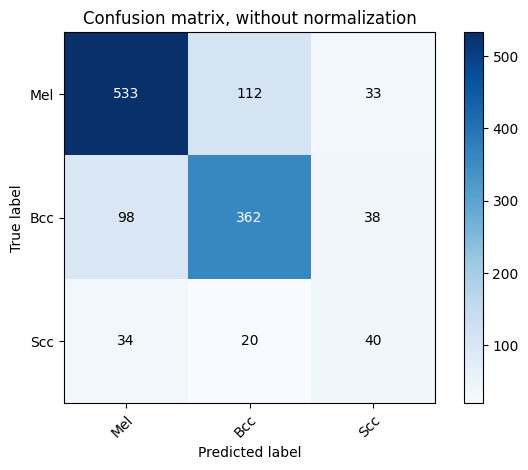

In [ ]:
# -----------  Using the original training set
strt= time.time()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
knn = KNeighborsClassifier(n_neighbors = 1)
baseline_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])

baseline_pipe.fit(train_features_sift, train_labels_sift)
y_pred = baseline_pipe.predict(test_features_sift)  # Predictions
scores = validate_mc(y_pred, test_labels) # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores - all training data :', scores)
ax = plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

#### ORB

Total Time = 0.10644936561584473
Scores - all training data : {'confusion_matrix': array([[476, 165,  37],
       [144, 319,  35],
       [ 37,  38,  19]], dtype=int64), 'accuracy': 0.6409448818897637, 'kappa': 0.3557774455360957, 'bma': 0.5149182684418714}
Confusion matrix, without normalization
[[476 165  37]
 [144 319  35]
 [ 37  38  19]]


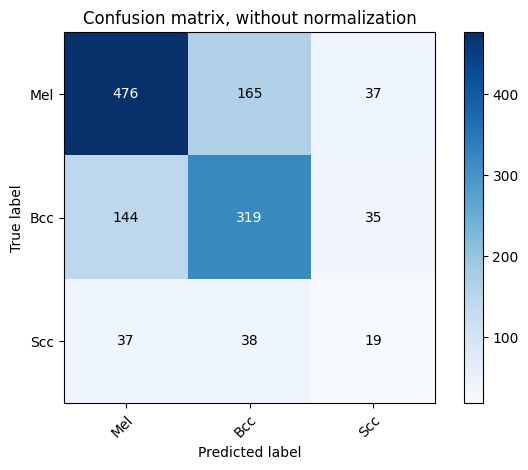

In [ ]:
# -----------  Using the original training set
strt= time.time()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
knn = KNeighborsClassifier(n_neighbors = 1)
baseline_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])

baseline_pipe.fit(train_features_orb, train_labels_orb)
y_pred = baseline_pipe.predict(test_features_orb)  # Predictions
scores = validate_mc(y_pred, test_labels) # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores - all training data :', scores)
ax = plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

#### BRISK

Total Time = 0.10421895980834961
Scores - all training data : {'confusion_matrix': array([[445, 196,  37],
       [176, 270,  52],
       [ 41,  36,  17]], dtype=int64), 'accuracy': 0.5763779527559055, 'kappa': 0.24426835850742845, 'bma': 0.45978730713981264}
Confusion matrix, without normalization
[[445 196  37]
 [176 270  52]
 [ 41  36  17]]


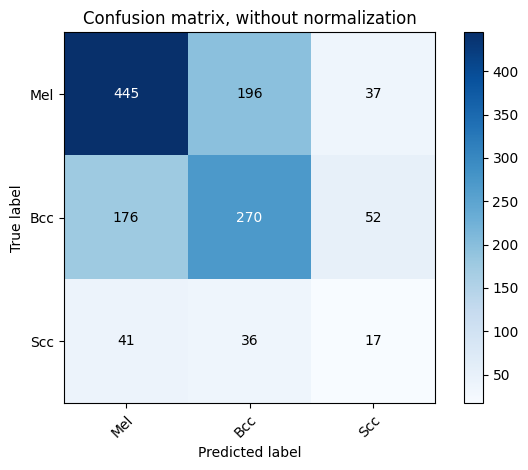

In [ ]:
# -----------  Using the original training set
strt= time.time()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
knn = KNeighborsClassifier(n_neighbors = 1)
baseline_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])

baseline_pipe.fit(train_features_brisk, train_labels_brisk)
y_pred = baseline_pipe.predict(test_features_brisk)  # Predictions
scores = validate_mc(y_pred, test_labels) # Compute the scores

end = time.time()
print('Total Time =', (end-strt))
print('Scores - all training data :', scores)
ax = plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

### Training 

#### K-NN

##### All samples

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Training best_score_ : 0.6024891341274901
Best Parameters {'knn__n_neighbors': 1}
Total Time = 1.2156586647033691
Scores classifier : {'confusion_matrix': array([[533, 112,  33],
       [ 98, 362,  38],
       [ 34,  20,  40]], dtype=int64), 'accuracy': 0.7362204724409449, 'kappa': 0.5301926712486086, 'bma': 0.6461917462103483}
Confusion matrix, without normalization
[[533 112  33]
 [ 98 362  38]
 [ 34  20  40]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

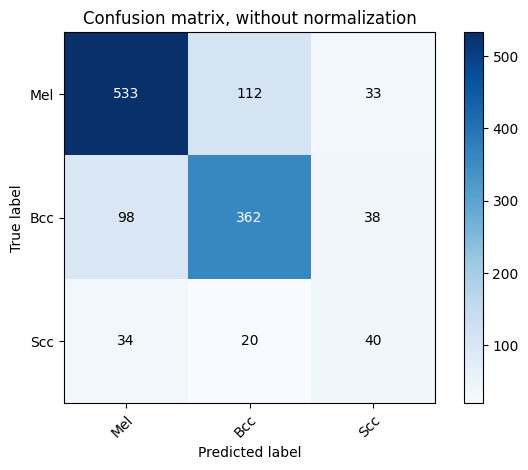

In [ ]:
strt = time.time()
svm = KNeighborsClassifier()
scaler = StandardScaler()
knn_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
params = {'knn__n_neighbors':[1, 2, 5, 10, 13, 15, 20, 30, 50, 75, 100]}
 
grid_search = GridSearchCV(knn_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sift, train_labels_sift)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_all = grid_search.best_estimator_

# Evaluation
y_pred = knn_all.predict(test_features_sift)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'knn_all_sift' + '.pkl'), 'wb') as f:
        pickle.dump(knn_all, f)
print("Model saved..\n")

Model saved..



##### Sampled I 

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Training best_score_ : 0.7595480383771739
Best Parameters {'knn__n_neighbors': 2}
Total Time = 1.258241891860962
Scores classifier : {'confusion_matrix': array([[498,  89,  91],
       [100, 302,  96],
       [ 28,  13,  53]], dtype=int64), 'accuracy': 0.6716535433070866, 'kappa': 0.45104278961771294, 'bma': 0.6349229214605235}
Confusion matrix, without normalization
[[498  89  91]
 [100 302  96]
 [ 28  13  53]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

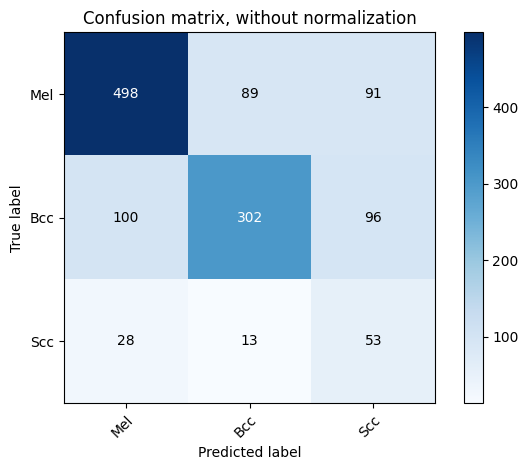

In [ ]:
strt = time.time()
svm = KNeighborsClassifier()
scaler = StandardScaler()
knn_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
params = {'knn__n_neighbors':[1, 2, 5, 10, 13, 15, 20, 30, 50, 75, 100]}
 
grid_search = GridSearchCV(knn_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm1, train_labels_sm1)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = knn_sm1.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'knn_sm1_sift' + '.pkl'), 'wb') as f:
        pickle.dump(knn_sm1, f)
print("Model saved..\n")

Model saved..



##### Sampled II

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Training best_score_ : 0.6026666666666667
Best Parameters {'knn__n_neighbors': 1}
Total Time = 0.45015549659729004
Scores classifier : {'confusion_matrix': array([[375, 134, 169],
       [ 79, 264, 155],
       [ 20,  20,  54]], dtype=int64), 'accuracy': 0.5456692913385827, 'kappa': 0.3006607929515419, 'bma': 0.5525619707222791}
Confusion matrix, without normalization
[[375 134 169]
 [ 79 264 155]
 [ 20  20  54]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

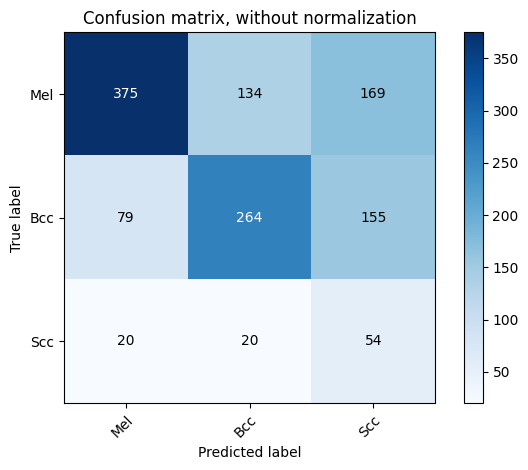

In [ ]:
strt = time.time()
svm = KNeighborsClassifier()
scaler = StandardScaler()
knn_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
params = {'knn__n_neighbors':[1, 2, 5, 10, 13, 15, 20, 30, 50, 75, 100]}
 
grid_search = GridSearchCV(knn_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm2, train_labels_sm2)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = knn_sm2.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'knn_sm2_sift' + '.pkl'), 'wb') as f:
        pickle.dump(knn_sm2, f)
print("Model saved..\n")

Model saved..



#### SVM

##### All samples

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training best_score_ : 0.6294598372143223
Best Parameters {'svm__C': 1, 'svm__class_weight': 'balanced'}
Total Time = 208.21305060386658
Scores classifier : {'confusion_matrix': array([[485, 113,  80],
       [ 61, 350,  87],
       [ 19,  27,  48]], dtype=int64), 'accuracy': 0.6952755905511812, 'kappa': 0.49100041425020713, 'bma': 0.642929591963536}
Confusion matrix, without normalization
[[485 113  80]
 [ 61 350  87]
 [ 19  27  48]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

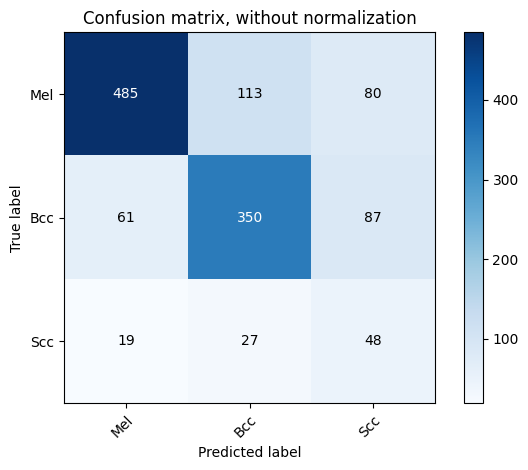

In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', random_state=42, kernel = 'rbf')
scaler = StandardScaler()
svm_pipe = Pipeline(steps=[("scaler", scaler), ("svm", svm)])

params = {'svm__C': range(1,11), 'svm__class_weight': ['balanced', None] }  
grid_search = GridSearchCV(svm_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sift, train_labels_sift)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_all = grid_search.best_estimator_

# Evaluation
y_pred = svm_all.predict(test_features_sift)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'svm_all_sift' + '.pkl'), 'wb') as f:
        pickle.dump(svm_all, f)
print("Model saved..\n")

Model saved..



##### Sampled I 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training best_score_ : 0.81975586625008
Best Parameters {'svm__C': 5}
Total Time = 114.27595734596252
Scores classifier : {'confusion_matrix': array([[504, 134,  40],
       [ 69, 388,  41],
       [ 20,  32,  42]], dtype=int64), 'accuracy': 0.7354330708661417, 'kappa': 0.5378777377321875, 'bma': 0.6564292694533863}
Confusion matrix, without normalization
[[504 134  40]
 [ 69 388  41]
 [ 20  32  42]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

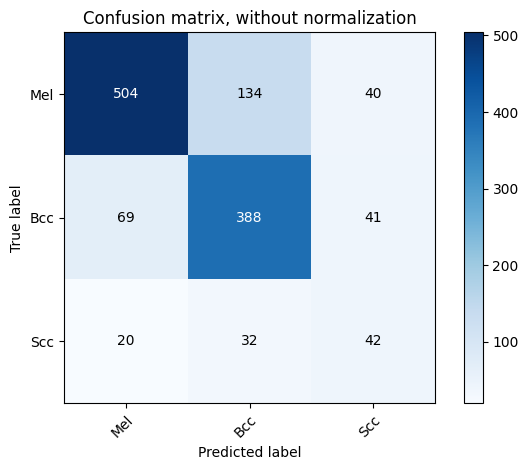

In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', random_state=42, kernel = 'rbf')
scaler = StandardScaler()
svm_pipe = Pipeline(steps=[("scaler", scaler), ("svm", svm)])

params = {'svm__C': range(1,11)}  
grid_search = GridSearchCV(svm_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm1, train_labels_sm1)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = svm_sm1.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'svm_sm1_sift' + '.pkl'), 'wb') as f:
        pickle.dump(svm_sm1, f)
print("Model saved..\n")

Model saved..



##### Sampled II

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training best_score_ : 0.6633333333333334
Best Parameters {'svm__C': 3}
Total Time = 12.248718976974487
Scores classifier : {'confusion_matrix': array([[471, 104, 103],
       [ 77, 300, 121],
       [ 17,  22,  55]], dtype=int64), 'accuracy': 0.6503937007874016, 'kappa': 0.4312606913468676, 'bma': 0.6274020956732219}
Confusion matrix, without normalization
[[471 104 103]
 [ 77 300 121]
 [ 17  22  55]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

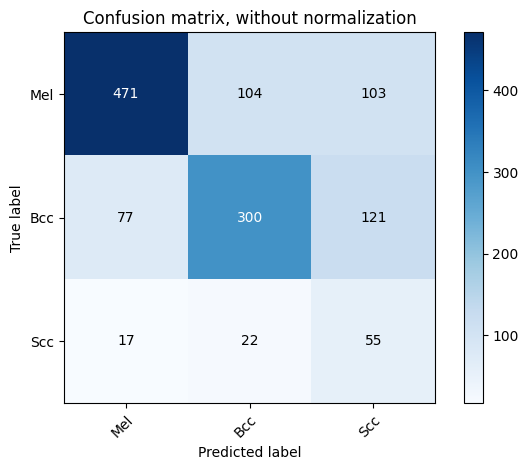

In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', random_state=42, kernel = 'rbf')
scaler = StandardScaler()
svm_pipe = Pipeline(steps=[("scaler", scaler), ("svm", svm)])

params = {'svm__C': range(1,11)}  
grid_search = GridSearchCV(svm_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm2, train_labels_sm2)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = svm_sm2.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'svm_sm2_sift' + '.pkl'), 'wb') as f:
        pickle.dump(svm_sm2, f)
print("Model saved..\n")

Model saved..



#### XGBOOST


##### All samples

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = xgb.XGBClassifier(objective='multi:softproba', seed=42)
pipeline = Pipeline(steps=[("scaler", scaler), ("xgb", model)])
params = {'xgb__n_estimators':[100, 500, 1000, 2000], 'xgb__max_depth': [5, 7, 9, 13, 20], 'xgb__learning_rate': [0.01, 0.1]} 
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sift, train_labels_sift)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgbt_all = grid_search.best_estimator_

# Evaluation
y_pred = xgbt_all.predict(test_features_sift)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Training best_score_ : 0.5656866323737199
Best Parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 2000}
Total Time = 2123.808038711548
Scores classifier : {'confusion_matrix': array([[560, 111,   7],
       [106, 385,   7],
       [ 42,  41,  11]], dtype=int64), 'accuracy': 0.752755905511811, 'kappa': 0.5379677905225351, 'bma': 0.5720241160461844}


Confusion matrix, without normalization
[[560 111   7]
 [106 385   7]
 [ 42  41  11]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

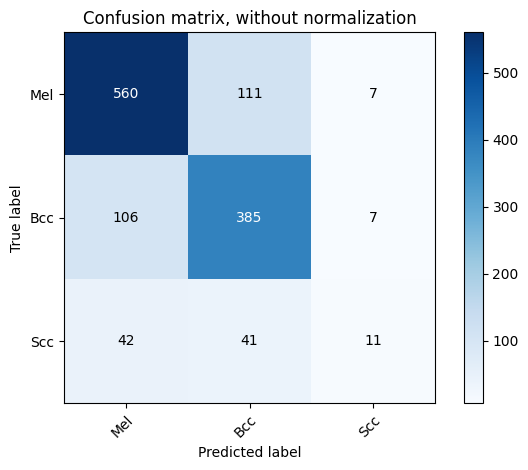

In [ ]:
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'xgbt_all_sift' + '.pkl'), 'wb') as f:
        pickle.dump(xgbt_all, f)
print("Model saved..\n")

Model saved..



##### Sampled I 

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Training best_score_ : 0.8278257783363298
Best Parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 9, 'xgb__n_estimators': 500}
Total Time = 2524.2582066059113
Scores classifier : {'confusion_matrix': array([[520, 133,  25],
       [ 71, 410,  17],
       [ 28,  46,  20]], dtype=int64), 'accuracy': 0.7480314960629921, 'kappa': 0.5454484446373207, 'bma': 0.6010069273516586}
Confusion matrix, without normalization
[[520 133  25]
 [ 71 410  17]
 [ 28  46  20]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

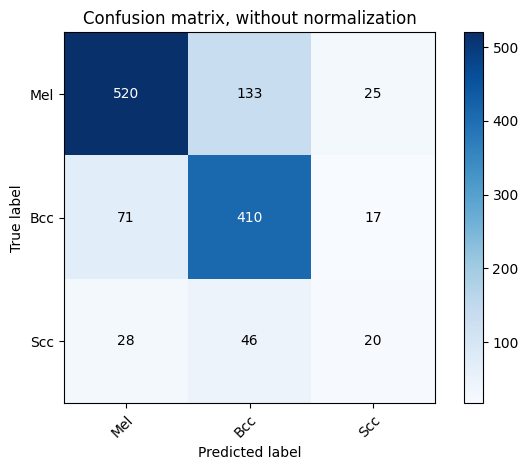

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = xgb.XGBClassifier(objective='multi:softproba', seed=42)
pipeline = Pipeline(steps=[("scaler", scaler), ("xgb", model)])
params = {'xgb__n_estimators':[100, 500, 1000, 2000], 'xgb__max_depth': [5, 7, 9, 13, 20], 'xgb__learning_rate': [0.01, 0.1]} 
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm1, train_labels_sm1)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgbt_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = xgbt_sm1.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'xgbt_sm1_sift' + '.pkl'), 'wb') as f:
        pickle.dump(xgbt_sm1, f)
print("Model saved..\n")

Model saved..



##### Sampled II

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Training best_score_ : 0.666
Best Parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 500}
Total Time = 550.4893727302551
Scores classifier : {'confusion_matrix': array([[463, 129,  86],
       [ 80, 331,  87],
       [ 21,  23,  50]], dtype=int64), 'accuracy': 0.6645669291338583, 'kappa': 0.44167874082054714, 'bma': 0.6264881278708003}
Confusion matrix, without normalization
[[463 129  86]
 [ 80 331  87]
 [ 21  23  50]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

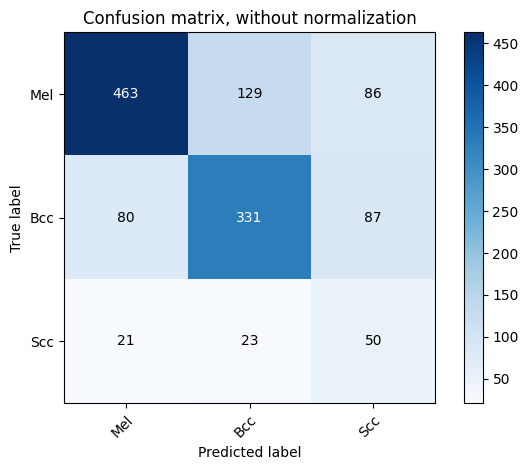

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = xgb.XGBClassifier(objective='multi:softproba', seed=42)
pipeline = Pipeline(steps=[("scaler", scaler), ("xgb", model)])
params = {'xgb__n_estimators':[100, 500, 1000, 2000], 'xgb__max_depth': [5, 7, 9, 13, 20], 'xgb__learning_rate': [0.01, 0.1]} 
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm2, train_labels_sm2)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgbt_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = xgbt_sm2.predict(test_features)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'xgbt_sm2_sift' + '.pkl'), 'wb') as f:
        pickle.dump(xgbt_sm2, f)
print("Model saved..\n")

Model saved..



#### Random Forest

##### All samples

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Training best_score_ : 0.736125628101797
Best Parameters {'rf__criterion': 'gini', 'rf__max_depth': 13, 'rf__n_estimators': 500}
Total Time = 610.202273607254
Scores classifier : {'confusion_matrix': array([[565, 110,   3],
       [121, 376,   1],
       [ 50,  40,   4]], dtype=int64), 'accuracy': 0.7440944881889764, 'kappa': 0.515091777178357, 'bma': 0.5436355350479934}
Confusion matrix, without normalization
[[565 110   3]
 [121 376   1]
 [ 50  40   4]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

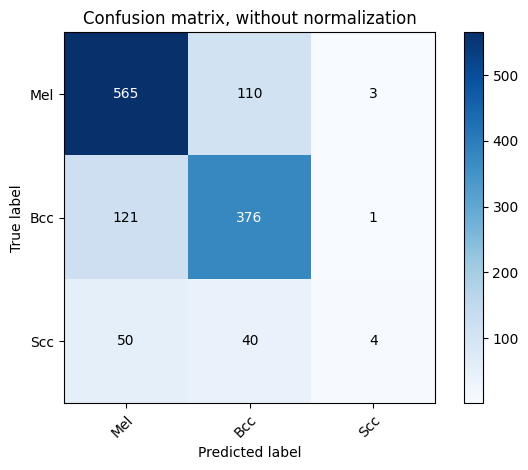

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = RandomForestClassifier(random_state=42, class_weight = 'balanced') 
pipeline = Pipeline(steps=[("scaler", scaler), ("rf", model)])
params = {'rf__n_estimators':[50, 100, 500, 1000, 2000], 'rf__criterion' : ['entropy','gini'], 'rf__max_depth': [5, 7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy', verbose=4)

# Grid Search - Training
grid_search.fit(train_features_sift, train_labels_sift)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
rf_all = grid_search.best_estimator_

# Evaluation
y_pred = rf_all.predict(test_features_sift)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'rf_all_sift' + '.pkl'), 'wb') as f:
        pickle.dump(rf_all, f)
print("Model saved..\n")

Model saved..



##### Sampled I 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Training best_score_ : 0.8215298585464426
Best Parameters {'rf__criterion': 'gini', 'rf__max_depth': 40, 'rf__n_estimators': 500}
Total Time = 877.5421571731567
Scores classifier : {'confusion_matrix': array([[517, 135,  26],
       [ 94, 387,  17],
       [ 33,  40,  21]], dtype=int64), 'accuracy': 0.7283464566929134, 'kappa': 0.5079045257284562, 'bma': 0.5876831874034769}
Confusion matrix, without normalization
[[517 135  26]
 [ 94 387  17]
 [ 33  40  21]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

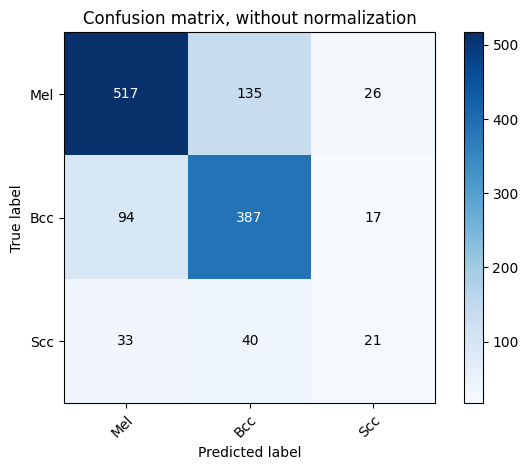

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = RandomForestClassifier(random_state=42)
pipeline = Pipeline(steps=[("scaler", scaler), ("rf", model)])
params = {'rf__n_estimators':[50, 100, 500, 1000, 2000], 'rf__criterion' : ['entropy','gini'], 'rf__max_depth': [5, 7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy', verbose=4)

# Grid Search - Training
grid_search.fit(train_features_sm1, train_labels_sm1)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# # Final model
rf_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = rf_sm1.predict(test_features_sift)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'rf_sm1_sift' + '.pkl'), 'wb') as f:
        pickle.dump(rf_sm1, f)
print("Model saved..\n")

Model saved..



##### Sampled II

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Training best_score_ : 0.6713333333333334
Best Parameters {'rf__criterion': 'gini', 'rf__max_depth': 20, 'rf__n_estimators': 2000}
Total Time = 271.7418496608734
Scores classifier : {'confusion_matrix': array([[491, 106,  81],
       [ 88, 318,  92],
       [ 23,  24,  47]], dtype=int64), 'accuracy': 0.6740157480314961, 'kappa': 0.45285964035964044, 'bma': 0.620914335809314}
Confusion matrix, without normalization
[[491 106  81]
 [ 88 318  92]
 [ 23  24  47]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

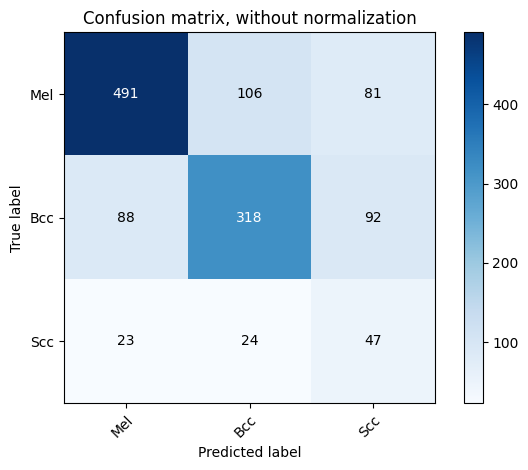

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = RandomForestClassifier(random_state=42) 
pipeline = Pipeline(steps=[("scaler", scaler), ("rf", model)])
params = {'rf__n_estimators':[50, 100, 500, 1000, 2000], 'rf__criterion' : ['entropy','gini'], 'rf__max_depth': [5, 7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy', verbose=4)

# Grid Search - Training
grid_search.fit(train_features_sm2, train_labels_sm2)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
rf_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = rf_sm2.predict(test_features_sift)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'rf_sm2_sift' + '.pkl'), 'wb') as f:
        pickle.dump(rf_sm2, f)
print("Model saved..\n")

Model saved..



#### Extra Trees

##### All samples

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Training best_score_ : 0.5748242025114532
Best Parameters {'xtree__criterion': 'gini', 'xtree__max_depth': 9, 'xtree__n_estimators': 500}
Total Time = 239.9721450805664
Scores classifier : {'confusion_matrix': array([[518, 119,  41],
       [117, 339,  42],
       [ 34,  34,  26]], dtype=int64), 'accuracy': 0.6952755905511812, 'kappa': 0.45635004911200183, 'bma': 0.5737768118857153}
Confusion matrix, without normalization
[[518 119  41]
 [117 339  42]
 [ 34  34  26]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

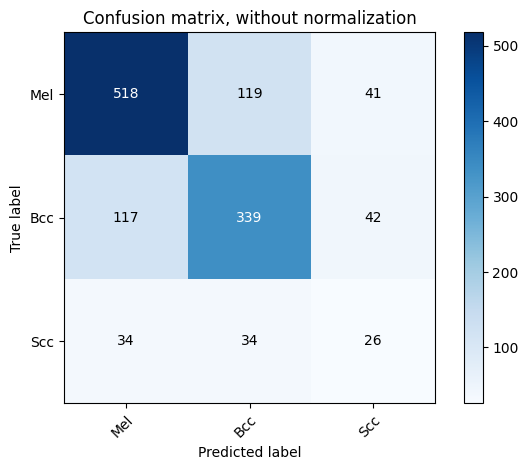

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = ExtraTreesClassifier(random_state=42, class_weight='balanced') 
pipeline = Pipeline(steps=[("scaler", scaler), ("xtree", model)])
params = {'xtree__n_estimators':[50, 100, 500, 1000, 2000], 'xtree__criterion' : ['entropy','gini'], 'xtree__max_depth': [7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4) 

# Grid Search - Training
grid_search.fit(train_features_sift, train_labels_sift)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xtree_all = grid_search.best_estimator_

# Evaluation
y_pred = xtree_all.predict(test_features_sift)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'xtree_all_sift' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_all, f)
print("Model saved..\n")

Model saved..



##### Sampled I 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Training best_score_ : 0.8421916182297394
Best Parameters {'xtree__criterion': 'gini', 'xtree__max_depth': 40, 'xtree__n_estimators': 1000}
Total Time = 253.63466835021973
Scores classifier : {'confusion_matrix': array([[530, 136,  12],
       [ 89, 404,   5],
       [ 31,  43,  20]], dtype=int64), 'accuracy': 0.7511811023622047, 'kappa': 0.5431176200039163, 'bma': 0.601907283940255}
Confusion matrix, without normalization
[[530 136  12]
 [ 89 404   5]
 [ 31  43  20]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

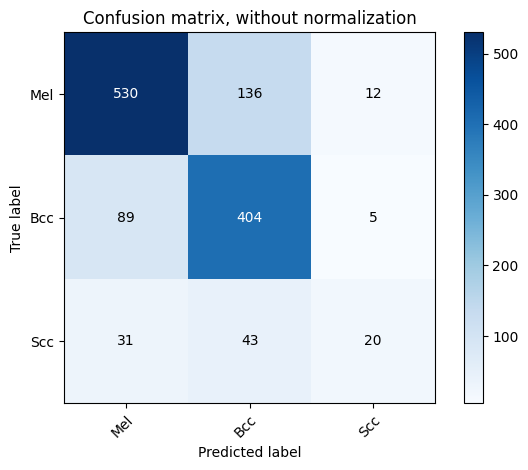

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = ExtraTreesClassifier(random_state=42) 
pipeline = Pipeline(steps=[("scaler", scaler), ("xtree", model)])
params = {'xtree__n_estimators':[50, 100, 500, 1000, 2000], 'xtree__criterion' : ['entropy','gini'], 'xtree__max_depth': [7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4) 

# Grid Search - Training
grid_search.fit(train_features_sm1, train_labels_sm1)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xtree_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = xtree_sm1.predict(test_features_sift)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'xtree_sm1_sift' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_sm1, f)
print("Model saved..\n")

Model saved..



##### Sampled II

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Training best_score_ : 0.6779999999999999
Best Parameters {'xtree__criterion': 'gini', 'xtree__max_depth': 20, 'xtree__n_estimators': 2000}
Total Time = 111.34048700332642
Scores classifier : {'confusion_matrix': array([[503, 107,  68],
       [ 99, 326,  73],
       [ 24,  24,  46]], dtype=int64), 'accuracy': 0.6889763779527559, 'kappa': 0.4682012661824134, 'bma': 0.6286226938759872}
Confusion matrix, without normalization
[[503 107  68]
 [ 99 326  73]
 [ 24  24  46]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

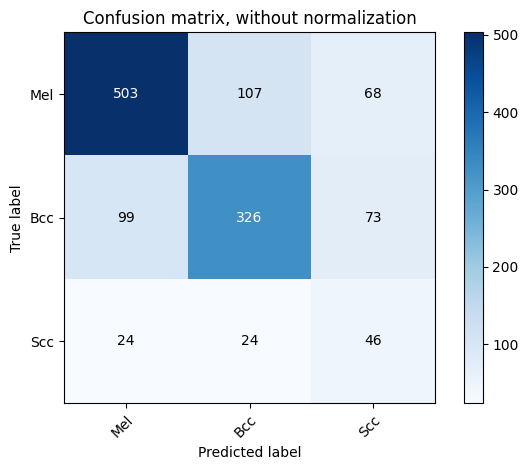

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = ExtraTreesClassifier(random_state=42) 
pipeline = Pipeline(steps=[("scaler", scaler), ("xtree", model)])
params = {'xtree__n_estimators':[50, 100, 500, 1000, 2000], 'xtree__criterion' : ['entropy','gini'], 'xtree__max_depth': [7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4) 

# Grid Search - Training
grid_search.fit(train_features_sm2, train_labels_sm2)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xtree_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = xtree_sm2.predict(test_features_sift)  # Predictions
scores = validate_mc(y_pred, test_labels)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels, y_pred, ['Mel', 'Bcc', 'Scc'])

In [ ]:
with open(os.path.join('models', 'xtree_sm2_sift' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_sm2, f)
print("Model saved..\n")

Model saved..



#### Ensembles

##### ALL 

In [ ]:
knn_probs = knn_all.predict_proba(test_features_sift) # bma = 0.646191746
svm_probs = svm_all.predict_proba(test_features_sift) # bma = 0.64292959
xtree_probs = xtree_all.predict_proba(test_features_sift) # bma = 0.573776811
xgb_probs = xgbt_all.predict_proba(test_features_sift) # bma = 0.572024116
rf_probs = rf_all.predict_proba(test_features_sift) # bma = 0.543635535047

{'confusion_matrix': array([[573,  98,   7],
       [ 97, 395,   6],
       [ 39,  37,  18]], dtype=int64), 'accuracy': 0.7763779527559055, 'kappa': 0.5831946601582724, 'bma': 0.6099315986093372}
Confusion matrix, without normalization
[[573  98   7]
 [ 97 395   6]
 [ 39  37  18]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

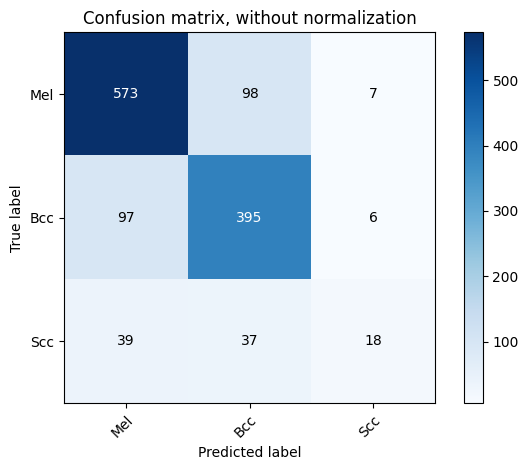

In [ ]:
y_probs = (rf_probs + xgb_probs + xtree_probs+ svm_probs + knn_probs)/5
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[570, 101,   7],
       [ 90, 401,   7],
       [ 38,  32,  24]], dtype=int64), 'accuracy': 0.7834645669291339, 'kappa': 0.5986333422206696, 'bma': 0.6337493323573589}
Confusion matrix, without normalization
[[570 101   7]
 [ 90 401   7]
 [ 38  32  24]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

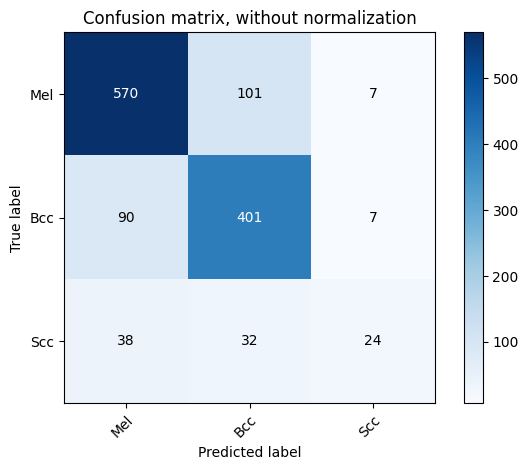

In [ ]:
y_probs = (xgb_probs + xtree_probs+ svm_probs + knn_probs)/4
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[552, 101,  25],
       [ 92, 371,  35],
       [ 36,  19,  39]], dtype=int64), 'accuracy': 0.75748031496063, 'kappa': 0.5644272612679224, 'bma': 0.6580109429117966}
Confusion matrix, without normalization
[[552 101  25]
 [ 92 371  35]
 [ 36  19  39]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

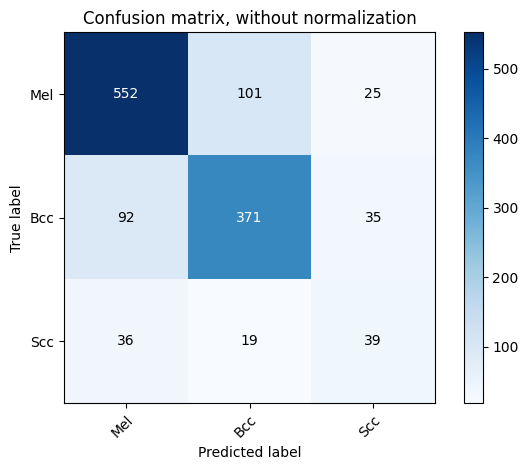

In [ ]:
y_probs = (xtree_probs+ svm_probs + knn_probs)/3
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[533, 112,  33],
       [ 98, 362,  38],
       [ 34,  20,  40]], dtype=int64), 'accuracy': 0.7362204724409449, 'kappa': 0.5301926712486086, 'bma': 0.6461917462103483}
Confusion matrix, without normalization
[[533 112  33]
 [ 98 362  38]
 [ 34  20  40]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

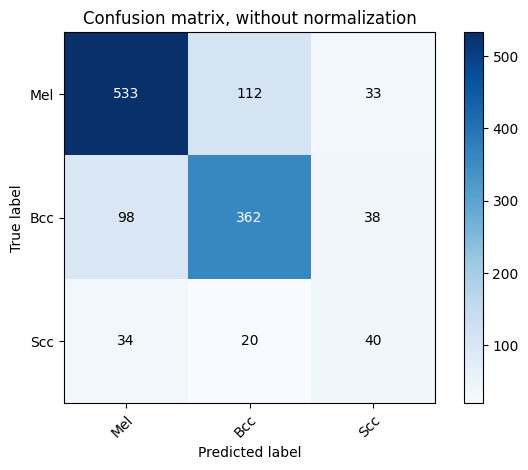

In [ ]:
y_probs = (svm_probs + knn_probs)/3
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

##### Sampled I

In [ ]:
svm_probs = svm_sm1.predict_proba(test_features_sift) # bma = 0.656429269
knn_probs = knn_sm1.predict_proba(test_features_sift) # bma = 0.63492292146
xtree_probs = xtree_sm1.predict_proba(test_features_sift) # bma = 0.60190728394
xgb_probs = xgbt_sm1.predict_proba(test_features_sift) # bma =  0.60100692735
rf_probs = rf_sm1.predict_proba(test_features_sift) # bma = 0.587683187

{'confusion_matrix': array([[522, 120,  36],
       [ 68, 402,  28],
       [ 24,  33,  37]], dtype=int64), 'accuracy': 0.7566929133858268, 'kappa': 0.5691010668435222, 'bma': 0.6569191471213417}
Confusion matrix, without normalization
[[522 120  36]
 [ 68 402  28]
 [ 24  33  37]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

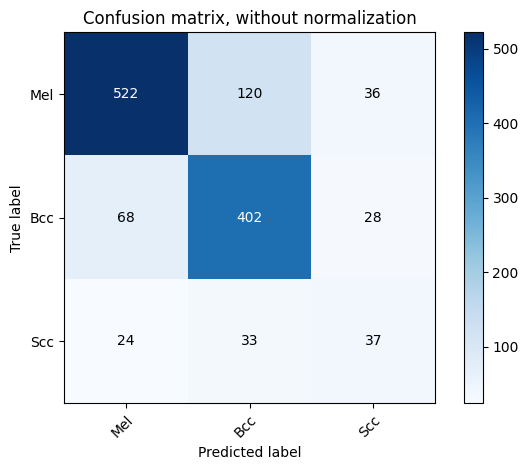

In [ ]:
y_probs = (svm_probs + knn_probs + xtree_probs+ xgb_probs + rf_probs)/5
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[524, 118,  36],
       [ 64, 405,  29],
       [ 24,  33,  37]], dtype=int64), 'accuracy': 0.7606299212598425, 'kappa': 0.5764288723493891, 'bma': 0.6599104634189806}
Confusion matrix, without normalization
[[524 118  36]
 [ 64 405  29]
 [ 24  33  37]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

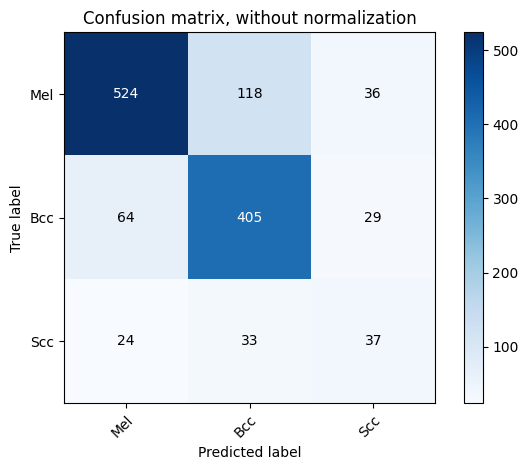

In [ ]:
y_probs = (svm_probs + knn_probs + xtree_probs+ xgb_probs)/4
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[508, 102,  68],
       [ 59, 368,  71],
       [ 22,  22,  50]], dtype=int64), 'accuracy': 0.7291338582677165, 'kappa': 0.5405016533862865, 'bma': 0.6733777512611168}
Confusion matrix, without normalization
[[508 102  68]
 [ 59 368  71]
 [ 22  22  50]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

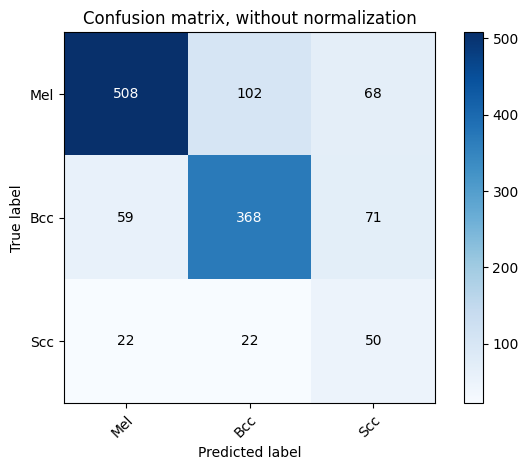

In [ ]:
y_probs = (svm_probs + knn_probs + xtree_probs)/3
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[466, 112, 100],
       [ 51, 343, 104],
       [ 18,  19,  57]], dtype=int64), 'accuracy': 0.6818897637795276, 'kappa': 0.4815195071868583, 'bma': 0.6608178776740049}
Confusion matrix, without normalization
[[466 112 100]
 [ 51 343 104]
 [ 18  19  57]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

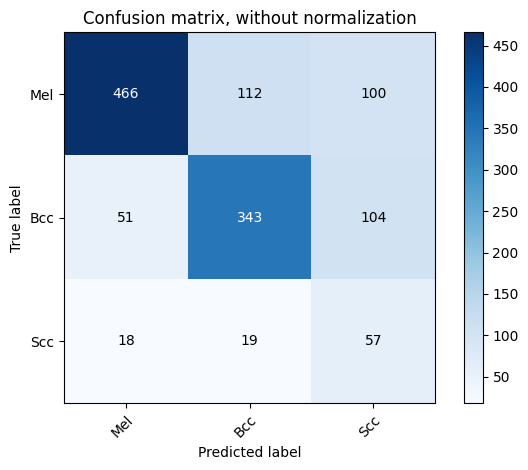

In [ ]:
y_probs = (svm_probs + knn_probs)/2
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

##### Sampled II

In [ ]:
xtree_probs = xtree_sm2.predict_proba(test_features_sift) # bma = 0.6286226938759872
svm_probs = svm_sm2.predict_proba(test_features_sift) # bma = 0.62740209567
xgb_probs = xgbt_sm2.predict_proba(test_features_sift) # bma =  0.6264881278708003
rf_probs = rf_sm2.predict_proba(test_features_sift) # bma = 0.620914335809314
knn_probs = knn_sm2.predict_proba(test_features_sift) # bma = 0.5525619707222

{'confusion_matrix': array([[470, 115,  93],
       [ 79, 314, 105],
       [ 21,  20,  53]], dtype=int64), 'accuracy': 0.6590551181102362, 'kappa': 0.43843413898885264, 'bma': 0.6291890716068315}
Confusion matrix, without normalization
[[470 115  93]
 [ 79 314 105]
 [ 21  20  53]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

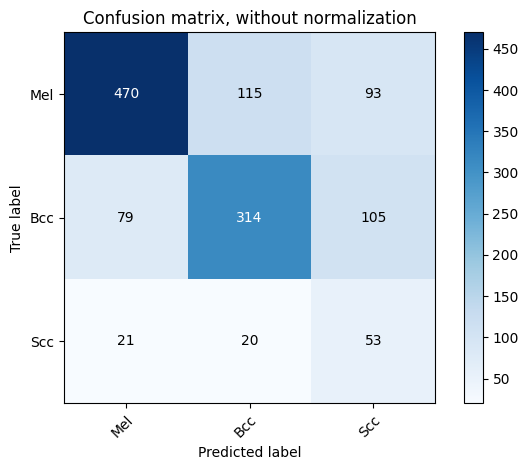

In [ ]:
y_probs = (xtree_probs + svm_probs + xgb_probs + rf_probs + knn_probs)/5
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[489, 106,  83],
       [ 76, 334,  88],
       [ 21,  21,  52]], dtype=int64), 'accuracy': 0.6889763779527559, 'kappa': 0.4801834512544402, 'bma': 0.6483710527794981}
Confusion matrix, without normalization
[[489 106  83]
 [ 76 334  88]
 [ 21  21  52]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

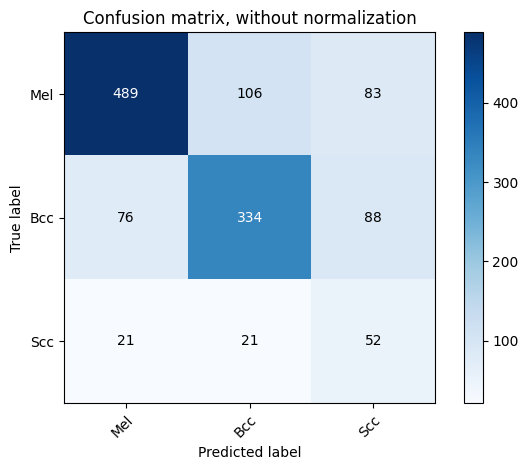

In [ ]:
y_probs = (xtree_probs + svm_probs + xgb_probs + rf_probs)/4
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[486, 107,  85],
       [ 75, 337,  86],
       [ 20,  21,  53]], dtype=int64), 'accuracy': 0.6897637795275591, 'kappa': 0.48219910674740984, 'bma': 0.6524502579451049}
Confusion matrix, without normalization
[[486 107  85]
 [ 75 337  86]
 [ 20  21  53]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

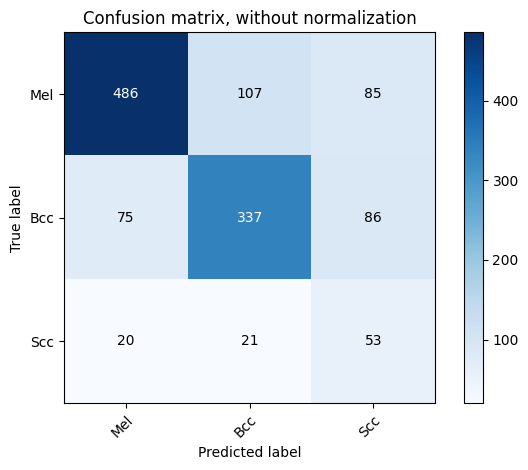

In [ ]:
y_probs = (xtree_probs + svm_probs + xgb_probs)/3
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[489, 108,  81],
       [ 86, 313,  99],
       [ 19,  26,  49]], dtype=int64), 'accuracy': 0.6700787401574804, 'kappa': 0.4491613148992377, 'bma': 0.6236765300075593}
Confusion matrix, without normalization
[[489 108  81]
 [ 86 313  99]
 [ 19  26  49]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

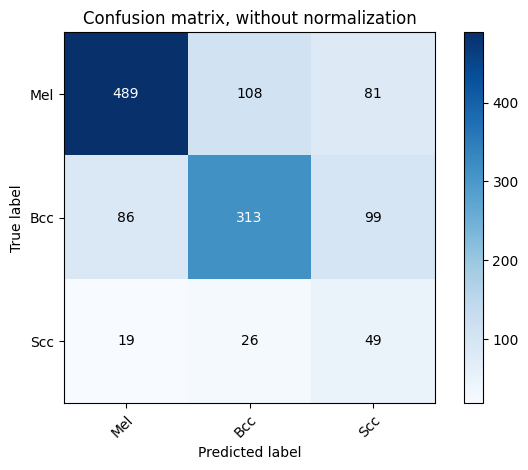

In [ ]:
y_probs = (xtree_probs + svm_probs)/2
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

##### Best

In [ ]:
svm_probs = svm_sm1.predict_proba(test_features_sift) # bma = 0.656429269453
knn_probs = knn_all.predict_proba(test_features_sift) # bma = 0.6461917462103483
xtree_probs = xtree_sm2.predict_proba(test_features_sift) # bma = 0.6286226938759872
xgb_probs = xgbt_sm2.predict_proba(test_features_sift) # bma =  0.6264881278708003
rf_probs = rf_sm2.predict_proba(test_features_sift) # bma = 0.620914335809314

{'confusion_matrix': array([[528, 116,  34],
       [ 80, 384,  34],
       [ 23,  29,  42]], dtype=int64), 'accuracy': 0.7511811023622047, 'kappa': 0.5596181279490837, 'bma': 0.6655513033115327}
Confusion matrix, without normalization
[[528 116  34]
 [ 80 384  34]
 [ 23  29  42]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

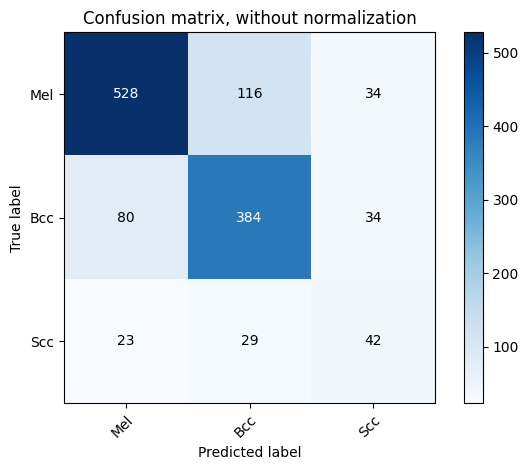

In [ ]:
y_probs = (svm_probs + knn_probs + xtree_probs + xgb_probs + rf_probs)/5
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[530, 115,  33],
       [ 73, 393,  32],
       [ 25,  27,  42]], dtype=int64), 'accuracy': 0.7598425196850394, 'kappa': 0.5746342084803016, 'bma': 0.6725586838661998}
Confusion matrix, without normalization
[[530 115  33]
 [ 73 393  32]
 [ 25  27  42]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

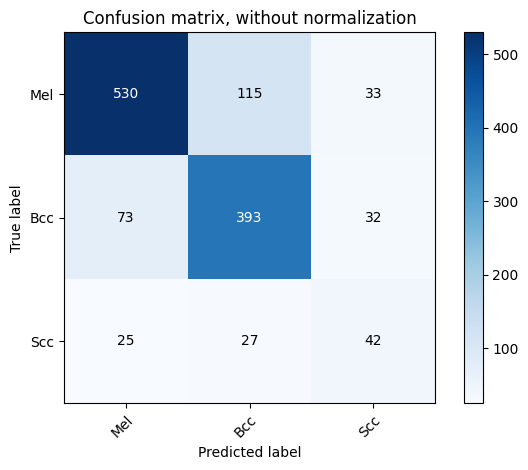

In [ ]:
y_probs = (svm_probs + knn_probs + xtree_probs + xgb_probs)/4
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[543, 110,  25],
       [ 84, 378,  36],
       [ 32,  23,  39]], dtype=int64), 'accuracy': 0.7559055118110236, 'kappa': 0.5636319301279067, 'bma': 0.6582715724506008}
Confusion matrix, without normalization
[[543 110  25]
 [ 84 378  36]
 [ 32  23  39]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

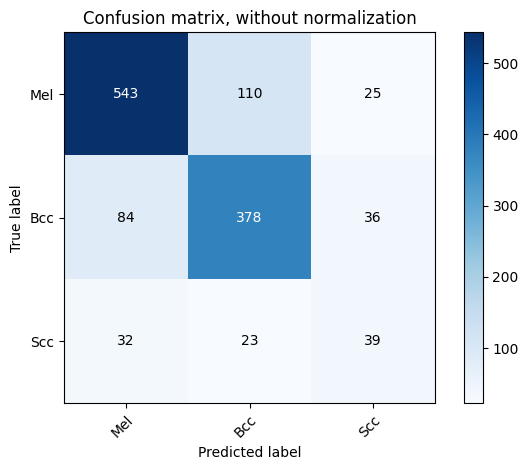

In [ ]:
y_probs = (svm_probs + knn_probs + xtree_probs)/3
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[533, 112,  33],
       [ 98, 362,  38],
       [ 34,  20,  40]], dtype=int64), 'accuracy': 0.7362204724409449, 'kappa': 0.5301926712486086, 'bma': 0.6461917462103483}
Confusion matrix, without normalization
[[533 112  33]
 [ 98 362  38]
 [ 34  20  40]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

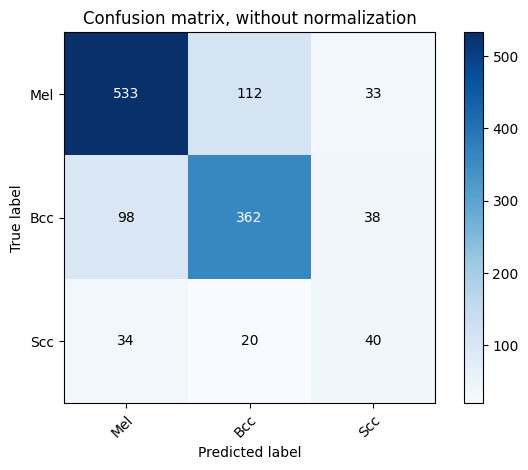

In [ ]:
y_probs = (svm_probs + knn_probs)/2
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels)
print(scores)
plot_confusion_matrix(test_labels, y_preds, ['Mel', 'Bcc', 'Scc'])

## Training with SIFT + ORB + BRISK

### Data

In [ ]:
train_features_all = np.hstack((train_features_sift, train_features_orb, train_features_brisk))
train_labels_all = train_labels_sift
test_features_all = np.hstack((test_features_sift, test_features_orb, test_features_brisk))
test_labels_all = test_labels_sift

# --  Train Features -  sampled I:    
with open(os.path.join('features_whole', 'sm_und_train_features_all' + '.pkl'), 'rb') as file:
    train_features_sm1_all = pickle.load(file)
with open(os.path.join('features_whole', 'sm_und_train_labels_all' + '.pkl'), 'rb') as file:
    train_labels_sm1_all = pickle.load(file)
    
# --  Train Features -  sampled II:    
with open(os.path.join('features_whole', 'sm_und_train_features_small_all' + '.pkl'), 'rb') as file:
    train_features_sm2_all = pickle.load(file)
with open(os.path.join('features_whole', 'sm_und_train_labels_small_all' + '.pkl'), 'rb') as file:
    train_labels_sm2_all = pickle.load(file)

### K-NN

#### All samples

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Training best_score_ : 0.6190988826474018
Best Parameters {'knn__n_neighbors': 1}
Total Time = 1.835850715637207
Scores classifier : {'confusion_matrix': array([[522, 119,  37],
       [ 95, 366,  37],
       [ 24,  25,  45]], dtype=int64), 'accuracy': 0.7346456692913386, 'kappa': 0.5312965429027001, 'bma': 0.6611915559054141}
Confusion matrix, without normalization
[[522 119  37]
 [ 95 366  37]
 [ 24  25  45]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

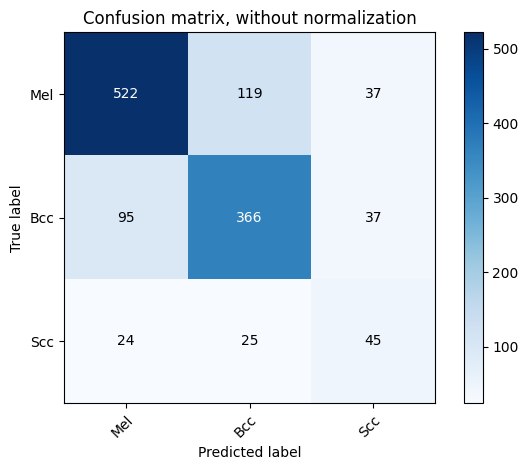

In [ ]:
strt = time.time()
knn = KNeighborsClassifier()
scaler = StandardScaler()
knn_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
params = {'knn__n_neighbors':[1, 2, 5, 10, 13, 15, 20, 30, 50, 75, 100]}
 
grid_search = GridSearchCV(knn_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_all = grid_search.best_estimator_

# Evaluation
y_pred = knn_all.predict(test_features_all)  # Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

#### Sampled I 

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Training best_score_ : 0.7343608361988212
Best Parameters {'knn__n_neighbors': 2}
Total Time = 1.5013833045959473
Scores classifier : {'confusion_matrix': array([[472,  93, 113],
       [ 90, 273, 135],
       [ 16,  15,  63]], dtype=int64), 'accuracy': 0.6362204724409449, 'kappa': 0.414456850198195, 'bma': 0.6381902429273991}
Confusion matrix, without normalization
[[472  93 113]
 [ 90 273 135]
 [ 16  15  63]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

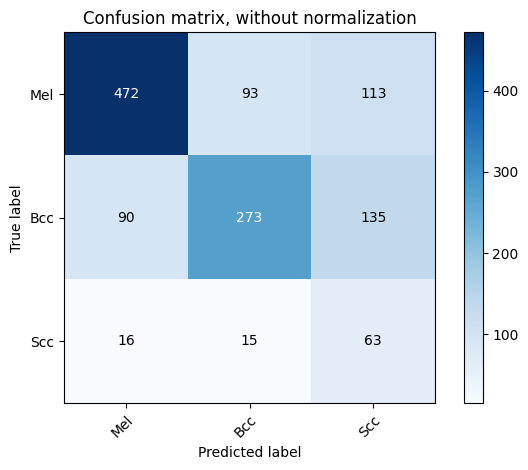

In [ ]:
strt = time.time()
knn = KNeighborsClassifier()
scaler = StandardScaler()
knn_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
params = {'knn__n_neighbors':[1, 2, 5, 10, 13, 15, 20, 30, 50, 75, 100]}
 
grid_search = GridSearchCV(knn_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm1_all, train_labels_sm1_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = knn_sm1.predict(test_features_all)  # Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

#### Sampled II

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Training best_score_ : 0.6053333333333334
Best Parameters {'knn__n_neighbors': 20}
Total Time = 0.6743619441986084
Scores classifier : {'confusion_matrix': array([[349, 117, 212],
       [ 34, 253, 211],
       [ 13,  16,  65]], dtype=int64), 'accuracy': 0.5251968503937008, 'kappa': 0.30778116842265113, 'bma': 0.571423584251019}
Confusion matrix, without normalization
[[349 117 212]
 [ 34 253 211]
 [ 13  16  65]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

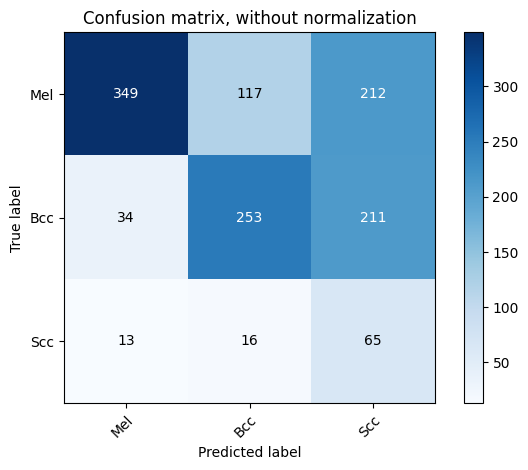

In [ ]:
strt = time.time()
knn = KNeighborsClassifier()
scaler = StandardScaler()
knn_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])
params = {'knn__n_neighbors':[1, 2, 5, 10, 13, 15, 20, 30, 50, 75, 100]}
 
grid_search = GridSearchCV(knn_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm2_all, train_labels_sm2_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
knn_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = knn_sm2.predict(test_features_all)  # Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

### SVM

#### All samples

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training best_score_ : 0.6539395461645373
Best Parameters {'svm__C': 1, 'svm__class_weight': 'balanced'}
Total Time = 330.9934597015381
Scores classifier : {'confusion_matrix': array([[499, 103,  76],
       [ 67, 361,  70],
       [ 22,  29,  43]], dtype=int64), 'accuracy': 0.7110236220472441, 'kappa': 0.509872170741864, 'bma': 0.6394448691647276}
Confusion matrix, without normalization
[[499 103  76]
 [ 67 361  70]
 [ 22  29  43]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

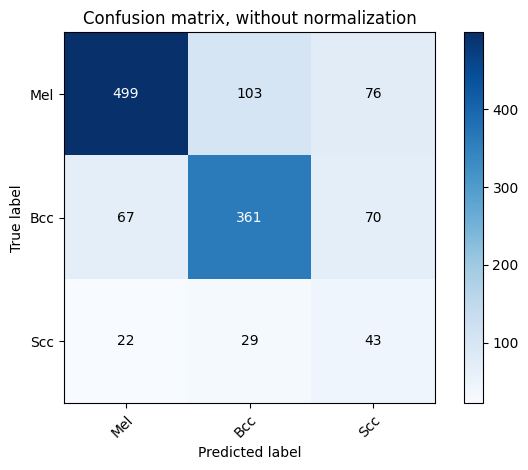

In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', random_state=42, kernel = 'rbf')
scaler = StandardScaler()
svm_pipe = Pipeline(steps=[("scaler", scaler), ("svm", svm)])

params = {'svm__C': range(1,11), 'svm__class_weight': ['balanced', None] }  
grid_search = GridSearchCV(svm_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_all = grid_search.best_estimator_

# Evaluation
y_pred = svm_all.predict(test_features_all)  # Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

#### Sampled I 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training best_score_ : 0.8421852181552657
Best Parameters {'svm__C': 10}
Total Time = 165.5639774799347
Scores classifier : {'confusion_matrix': array([[540, 113,  25],
       [ 65, 402,  31],
       [ 24,  41,  29]], dtype=int64), 'accuracy': 0.7645669291338583, 'kappa': 0.578807844181197, 'bma': 0.6373999103172245}
Confusion matrix, without normalization
[[540 113  25]
 [ 65 402  31]
 [ 24  41  29]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

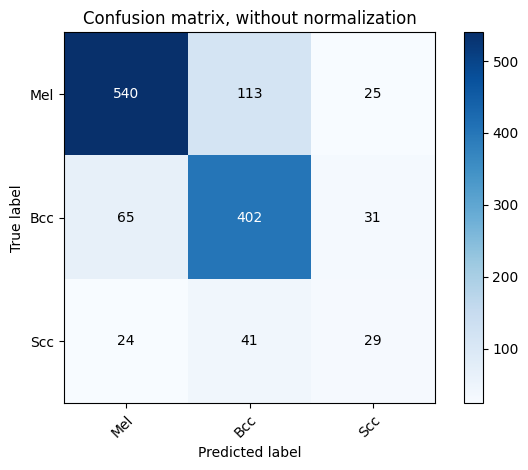

In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', random_state=42, kernel = 'rbf')
scaler = StandardScaler()
svm_pipe = Pipeline(steps=[("scaler", scaler), ("svm", svm)])

params = {'svm__C': range(1,11)}  
grid_search = GridSearchCV(svm_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm1_all, train_labels_sm1_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = svm_sm1.predict(test_features_all)  # Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

#### Sampled II

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training best_score_ : 0.6853333333333332
Best Parameters {'svm__C': 4}
Total Time = 13.4019136428833
Scores classifier : {'confusion_matrix': array([[459, 116, 103],
       [ 70, 325, 103],
       [  9,  27,  58]], dtype=int64), 'accuracy': 0.662992125984252, 'kappa': 0.4510914349420756, 'bma': 0.6488742896017636}
Confusion matrix, without normalization
[[459 116 103]
 [ 70 325 103]
 [  9  27  58]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

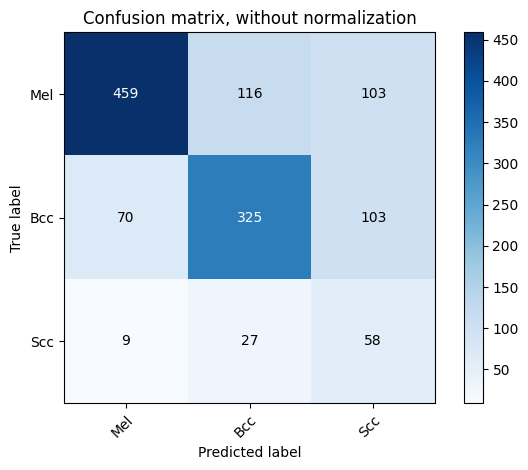

In [ ]:
strt = time.time()
svm = SVC(probability=True, gamma='auto', random_state=42, kernel = 'rbf')
scaler = StandardScaler()
svm_pipe = Pipeline(steps=[("scaler", scaler), ("svm", svm)])

params = {'svm__C': range(1,11)}  
grid_search = GridSearchCV(svm_pipe, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm2_all, train_labels_sm2_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
svm_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = svm_sm2.predict(test_features_all)  # Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

### XGBOOST


#### All samples

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Training best_score_ : 0.5658194948293145
Best Parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 2000}
Total Time = 45586.757830142975
Scores classifier : {'confusion_matrix': array([[572,  97,   9],
       [ 85, 406,   7],
       [ 40,  48,   6]], dtype=int64), 'accuracy': 0.7748031496062993, 'kappa': 0.5795422448800048, 'bma': 0.5742495495066313}
Confusion matrix, without normalization
[[572  97   9]
 [ 85 406   7]
 [ 40  48   6]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

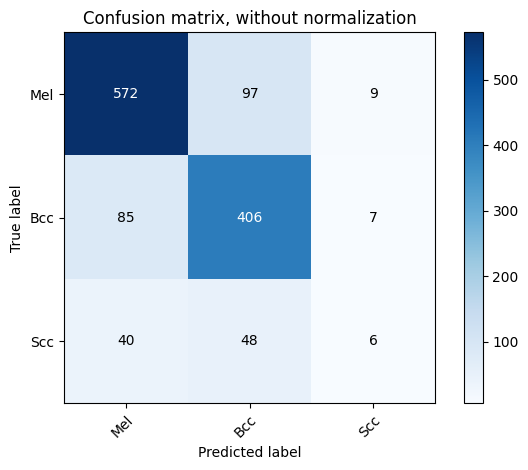

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = xgb.XGBClassifier(objective='multi:softproba', seed=42)
pipeline = Pipeline(steps=[("scaler", scaler), ("xgb", model)])
params = {'xgb__n_estimators':[100, 500, 1000, 2000], 'xgb__max_depth': [5, 7, 9, 13, 20], 'xgb__learning_rate': [0.01, 0.1]} 
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgbt_all = grid_search.best_estimator_

# Evaluation
y_pred = xgbt_all.predict(test_features_all)# Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

#### Sampled I 

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Training best_score_ : 0.8394296951819076
Best Parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 500}
Total Time = 5504.860229730606
Scores classifier : {'confusion_matrix': array([[527, 130,  21],
       [ 69, 416,  13],
       [ 30,  47,  17]], dtype=int64), 'accuracy': 0.7559055118110236, 'kappa': 0.5568258056382294, 'bma': 0.5978261883282833}
Confusion matrix, without normalization
[[527 130  21]
 [ 69 416  13]
 [ 30  47  17]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

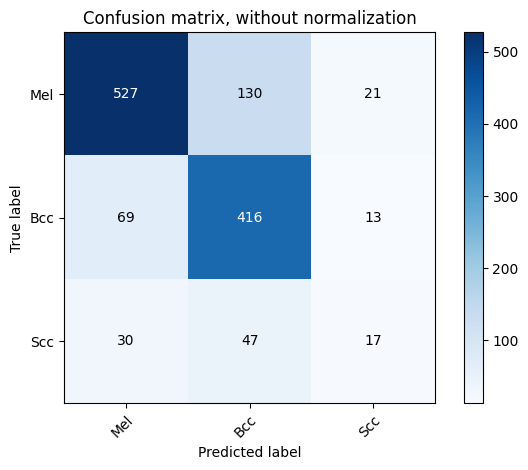

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = xgb.XGBClassifier(objective='multi:softproba', seed=42)
pipeline = Pipeline(steps=[("scaler", scaler), ("xgb", model)])
params = {'xgb__n_estimators':[100, 500, 1000, 2000], 'xgb__max_depth': [5, 7, 9, 13, 20], 'xgb__learning_rate': [0.01, 0.1]} 
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm1_all, train_labels_sm1_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgbt_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = xgbt_sm1.predict(test_features_all)  # Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

#### Sampled II

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Training best_score_ : 0.692
Best Parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 2000}
Total Time = 1169.3917977809906
Scores classifier : {'confusion_matrix': array([[474, 118,  86],
       [ 79, 329,  90],
       [ 19,  25,  50]], dtype=int64), 'accuracy': 0.6716535433070866, 'kappa': 0.4533456374176288, 'bma': 0.6305575027153111}
Confusion matrix, without normalization
[[474 118  86]
 [ 79 329  90]
 [ 19  25  50]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

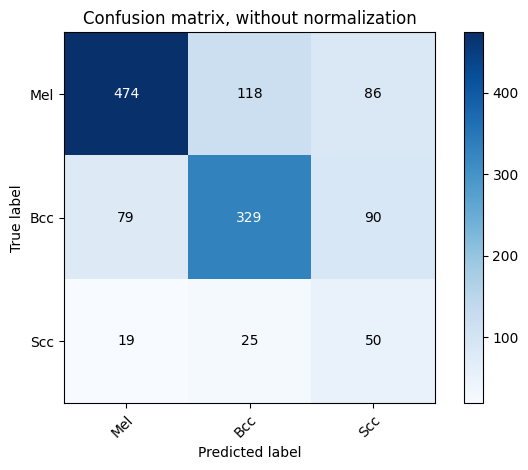

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = xgb.XGBClassifier(objective='multi:softproba', seed=42)
pipeline = Pipeline(steps=[("scaler", scaler), ("xgb", model)])
params = {'xgb__n_estimators':[100, 500, 1000, 2000], 'xgb__max_depth': [5, 7, 9, 13, 20], 'xgb__learning_rate': [0.01, 0.1]} 
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)  

# Grid Search - Training
grid_search.fit(train_features_sm2_all, train_labels_sm2_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xgbt_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = xgbt_sm2.predict(test_features_all) # Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

### Random Forest

#### All samples

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Training best_score_ : 0.7347451590675058
Best Parameters {'rf__criterion': 'entropy', 'rf__max_depth': 40, 'rf__n_estimators': 1000}
Total Time = 778.0192592144012
Scores classifier : {'confusion_matrix': array([[575, 103,   0],
       [120, 378,   0],
       [ 53,  41,   0]], dtype=int64), 'accuracy': 0.7503937007874015, 'kappa': 0.5240127689761173, 'bma': 0.5357062468161732}
Confusion matrix, without normalization
[[575 103   0]
 [120 378   0]
 [ 53  41   0]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

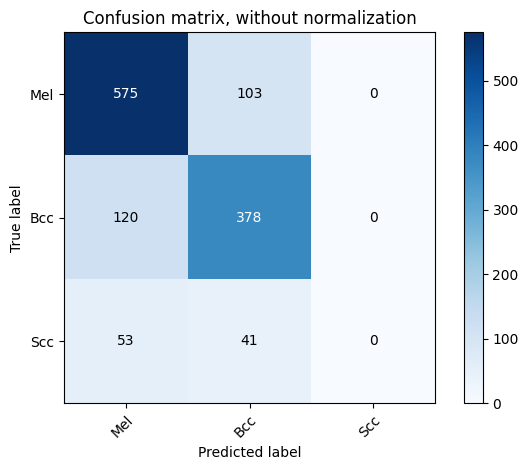

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = RandomForestClassifier(random_state=42, class_weight = 'balanced') 
pipeline = Pipeline(steps=[("scaler", scaler), ("rf", model)])
params = {'rf__n_estimators':[50, 100, 500, 1000, 2000], 'rf__criterion' : ['entropy','gini'], 'rf__max_depth': [5, 7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy', verbose=4)

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
rf_all = grid_search.best_estimator_

# Evaluation
y_pred = rf_all.predict(test_features_all)  # Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

#### Sampled I 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Training best_score_ : 0.8231005969386571
Best Parameters {'rf__criterion': 'gini', 'rf__max_depth': 40, 'rf__n_estimators': 2000}
Total Time = 991.3308074474335
Scores classifier : {'confusion_matrix': array([[516, 140,  22],
       [ 86, 396,  16],
       [ 34,  42,  18]], dtype=int64), 'accuracy': 0.7322834645669292, 'kappa': 0.5140583220044476, 'bma': 0.5825773438321162}
Confusion matrix, without normalization
[[516 140  22]
 [ 86 396  16]
 [ 34  42  18]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

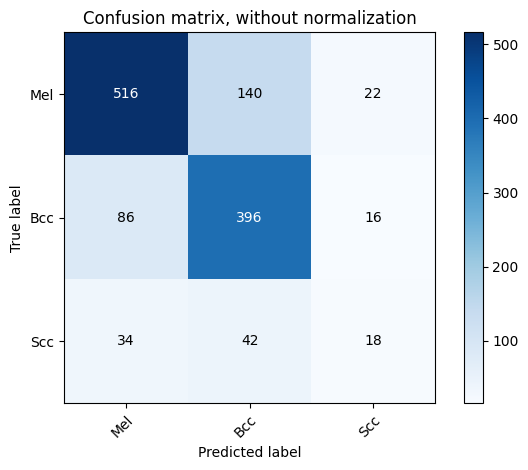

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = RandomForestClassifier(random_state=42)
pipeline = Pipeline(steps=[("scaler", scaler), ("rf", model)])
params = {'rf__n_estimators':[50, 100, 500, 1000, 2000], 'rf__criterion' : ['entropy','gini'], 'rf__max_depth': [5, 7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy', verbose=4)

# Grid Search - Training
grid_search.fit(train_features_sm1_all, train_labels_sm1_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
rf_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = rf_sm1.predict(test_features_all)  # Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

#### Sampled II

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Training best_score_ : 0.6933333333333332
Best Parameters {'rf__criterion': 'entropy', 'rf__max_depth': 40, 'rf__n_estimators': 2000}
Total Time = 193.2540352344513
Scores classifier : {'confusion_matrix': array([[480, 117,  81],
       [ 81, 335,  82],
       [ 27,  21,  46]], dtype=int64), 'accuracy': 0.6779527559055119, 'kappa': 0.45838320980651404, 'bma': 0.6233390223165933}
Confusion matrix, without normalization
[[480 117  81]
 [ 81 335  82]
 [ 27  21  46]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

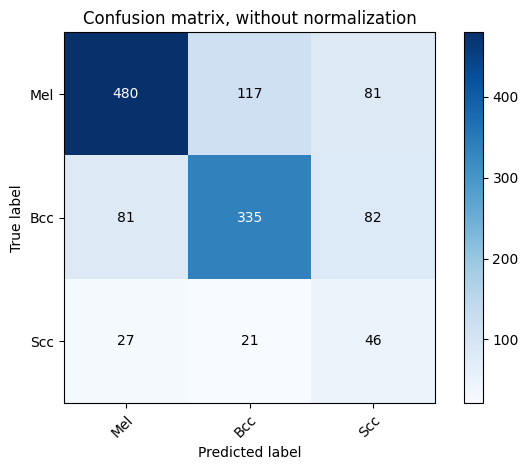

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = RandomForestClassifier(random_state=42) 
pipeline = Pipeline(steps=[("scaler", scaler), ("rf", model)])
params = {'rf__n_estimators':[50, 100, 500, 1000, 2000], 'rf__criterion' : ['entropy','gini'], 'rf__max_depth': [5, 7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='accuracy', verbose=4)

# Grid Search - Training
grid_search.fit(train_features_sm2_all, train_labels_sm2_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
rf_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = rf_sm2.predict(test_features_all)  # Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

### Extra Trees

#### All samples

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Training best_score_ : 0.5843593001660092
Best Parameters {'xtree__criterion': 'gini', 'xtree__max_depth': 7, 'xtree__n_estimators': 1000}
Total Time = 231.19218802452087
Scores classifier : {'confusion_matrix': array([[495, 113,  70],
       [ 89, 329,  80],
       [ 31,  31,  32]], dtype=int64), 'accuracy': 0.6740157480314961, 'kappa': 0.4425974378437517, 'bma': 0.5770521992570798}
Confusion matrix, without normalization
[[495 113  70]
 [ 89 329  80]
 [ 31  31  32]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

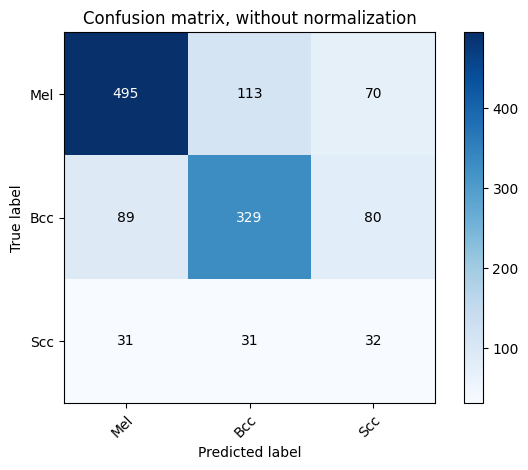

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = ExtraTreesClassifier(random_state=42, class_weight='balanced') 
pipeline = Pipeline(steps=[("scaler", scaler), ("xtree", model)])
params = {'xtree__n_estimators':[50, 100, 500, 1000, 2000], 'xtree__criterion' : ['entropy','gini'], 'xtree__max_depth': [7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4) 

# Grid Search - Training
grid_search.fit(train_features_all, train_labels_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xtree_all = grid_search.best_estimator_

# Evaluation
y_pred = xtree_all.predict(test_features_all)  # Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

#### Sampled I 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Training best_score_ : 0.8388391428554804
Best Parameters {'xtree__criterion': 'entropy', 'xtree__max_depth': 40, 'xtree__n_estimators': 2000}
Total Time = 332.221999168396
Scores classifier : {'confusion_matrix': array([[526, 139,  13],
       [ 81, 405,  12],
       [ 36,  41,  17]], dtype=int64), 'accuracy': 0.7464566929133858, 'kappa': 0.5361746144807342, 'bma': 0.5899717617725027}
Confusion matrix, without normalization
[[526 139  13]
 [ 81 405  12]
 [ 36  41  17]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

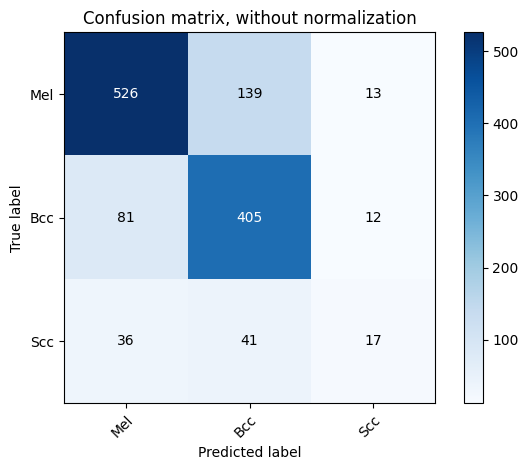

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = ExtraTreesClassifier(random_state=42) 
pipeline = Pipeline(steps=[("scaler", scaler), ("xtree", model)])
params = {'xtree__n_estimators':[50, 100, 500, 1000, 2000], 'xtree__criterion' : ['entropy','gini'], 'xtree__max_depth': [7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4) 

# Grid Search - Training
grid_search.fit(train_features_sm1_all, train_labels_sm1_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xtree_sm1 = grid_search.best_estimator_

# Evaluation
y_pred = xtree_sm1.predict(test_features_all)  # Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

#### Sampled II

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Training best_score_ : 0.6986666666666667
Best Parameters {'xtree__criterion': 'gini', 'xtree__max_depth': 40, 'xtree__n_estimators': 1000}
Total Time = 113.16420722007751
Scores classifier : {'confusion_matrix': array([[485, 122,  71],
       [ 76, 351,  71],
       [ 25,  27,  42]], dtype=int64), 'accuracy': 0.6913385826771653, 'kappa': 0.4755692639598187, 'bma': 0.6223223402616932}
Confusion matrix, without normalization
[[485 122  71]
 [ 76 351  71]
 [ 25  27  42]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

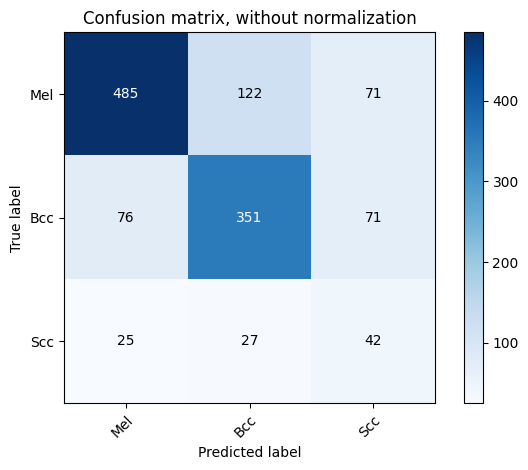

In [ ]:
strt = time.time()
scaler = StandardScaler()
model = ExtraTreesClassifier(random_state=42) 
pipeline = Pipeline(steps=[("scaler", scaler), ("xtree", model)])
params = {'xtree__n_estimators':[50, 100, 500, 1000, 2000], 'xtree__criterion' : ['entropy','gini'], 'xtree__max_depth': [7, 9, 13, 20, 40]}  
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4) 

# Grid Search - Training
grid_search.fit(train_features_sm2_all, train_labels_sm2_all)
print('Training best_score_ :',grid_search.best_score_)
print('Best Parameters', grid_search.best_params_)

# Final model
xtree_sm2 = grid_search.best_estimator_

# Evaluation
y_pred = xtree_sm2.predict(test_features_all)  # Predictions
scores = validate_mc(y_pred, test_labels_all)  # Compute the scores


end = time.time()
print('Total Time =', (end-strt))
print('Scores classifier :', scores)
plot_confusion_matrix(test_labels_all, y_pred, ['Mel', 'Bcc', 'Scc'])

### Ensemble

#### All

In [ ]:
knn_probs = knn_all.predict_proba(test_features_all) # bma = 0.6611915559
svm_probs = svm_all.predict_proba(test_features_all) # bma = 0.63944486916472
xtree_probs = xtree_all.predict_proba(test_features_all) # bma = 0.577052199257
xgb_probs = xgbt_all.predict_proba(test_features_all) # bma = 0.574249549506
rf_probs = rf_all.predict_proba(test_features_all) # bma = 0.535706246816

{'confusion_matrix': array([[586,  86,   6],
       [ 95, 400,   3],
       [ 40,  41,  13]], dtype=int64), 'accuracy': 0.7866141732283465, 'kappa': 0.5995918785222001, 'bma': 0.6019391694689383}
Confusion matrix, without normalization
[[586  86   6]
 [ 95 400   3]
 [ 40  41  13]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

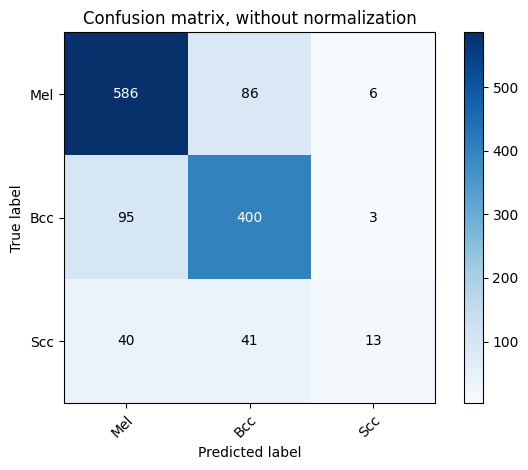

In [ ]:
y_probs = (rf_probs + xgb_probs + xtree_probs+ svm_probs + knn_probs)/5
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[575,  92,  11],
       [ 84, 405,   9],
       [ 39,  41,  14]], dtype=int64), 'accuracy': 0.7826771653543307, 'kappa': 0.5964243278344248, 'bma': 0.6034239260437219}
Confusion matrix, without normalization
[[575  92  11]
 [ 84 405   9]
 [ 39  41  14]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

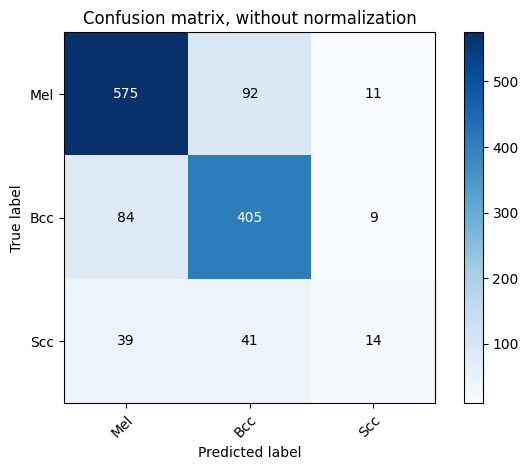

In [ ]:
y_probs = (xgb_probs + xtree_probs+ svm_probs + knn_probs)/4
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[539, 110,  29],
       [ 90, 375,  33],
       [ 24,  26,  44]], dtype=int64), 'accuracy': 0.7543307086614173, 'kappa': 0.5625157332697379, 'bma': 0.6720274684377378}
Confusion matrix, without normalization
[[539 110  29]
 [ 90 375  33]
 [ 24  26  44]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

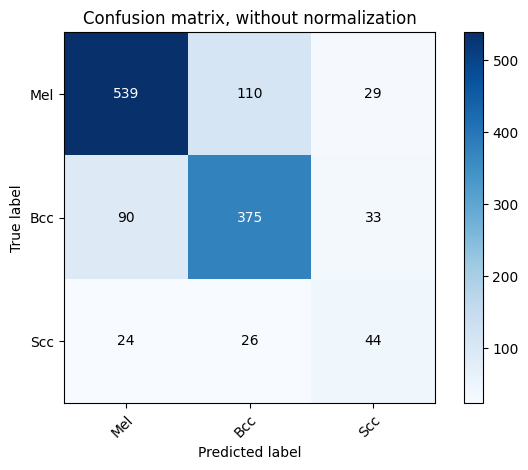

In [ ]:
y_probs = (xtree_probs+ svm_probs + knn_probs)/3
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[522, 119,  37],
       [ 95, 366,  37],
       [ 24,  25,  45]], dtype=int64), 'accuracy': 0.7346456692913386, 'kappa': 0.5312965429027001, 'bma': 0.6611915559054141}
Confusion matrix, without normalization
[[522 119  37]
 [ 95 366  37]
 [ 24  25  45]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

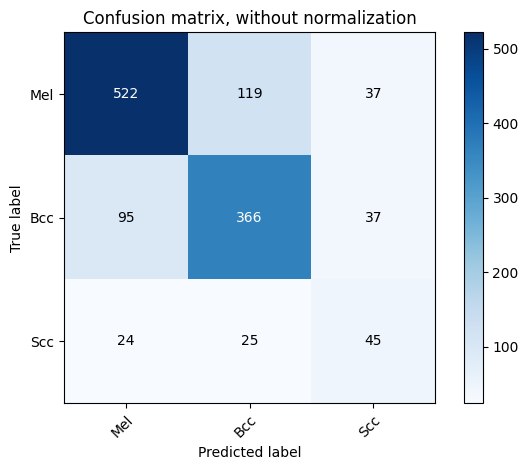

In [ ]:
y_probs = ( svm_probs + knn_probs)/2
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

#### Sampled I 

In [ ]:
knn_probs = knn_sm1.predict_proba(test_features_all) # bma = 0.63819024292
svm_probs = svm_sm1.predict_proba(test_features_all) # bma = 0.637399910317
xgb_probs = xgbt_sm1.predict_proba(test_features_all) # bma =  0.597826188328
xtree_probs = xtree_sm1.predict_proba(test_features_all) # bma = 0.5899717617
rf_probs = rf_sm1.predict_proba(test_features_all) # bma = 0.58257734383

{'confusion_matrix': array([[532, 114,  32],
       [ 64, 413,  21],
       [ 26,  36,  32]], dtype=int64), 'accuracy': 0.7692913385826772, 'kappa': 0.5878358919828981, 'bma': 0.6514678559842836}
Confusion matrix, without normalization
[[532 114  32]
 [ 64 413  21]
 [ 26  36  32]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

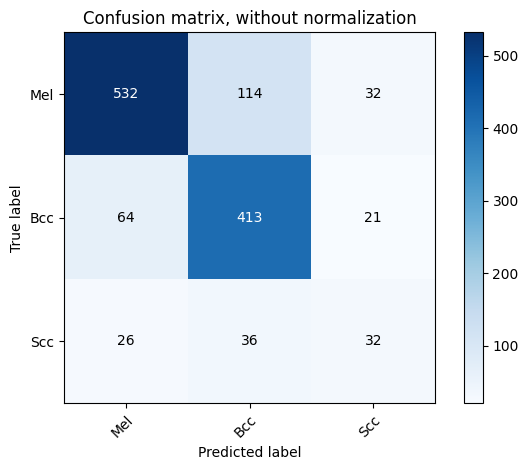

In [ ]:
y_probs = (knn_probs + svm_probs + xgb_probs + xtree_probs + rf_probs)/5
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[533, 113,  32],
       [ 61, 414,  23],
       [ 25,  36,  33]], dtype=int64), 'accuracy': 0.7716535433070866, 'kappa': 0.5928461194907647, 'bma': 0.6561749414024641}
Confusion matrix, without normalization
[[533 113  32]
 [ 61 414  23]
 [ 25  36  33]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

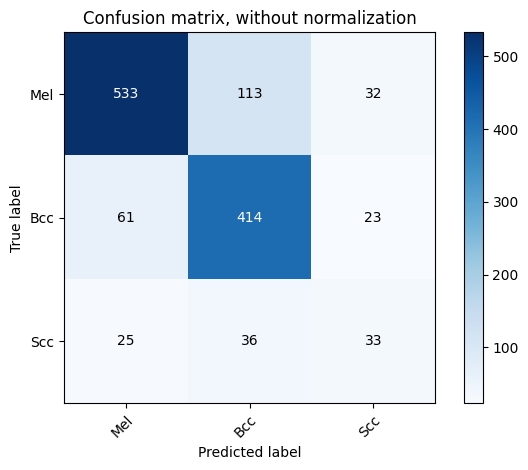

In [ ]:
y_probs = (knn_probs + svm_probs + xgb_probs + xtree_probs )/4
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[531, 109,  38],
       [ 56, 413,  29],
       [ 22,  38,  34]], dtype=int64), 'accuracy': 0.7700787401574803, 'kappa': 0.5932094811018578, 'bma': 0.6580684124812815}
Confusion matrix, without normalization
[[531 109  38]
 [ 56 413  29]
 [ 22  38  34]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

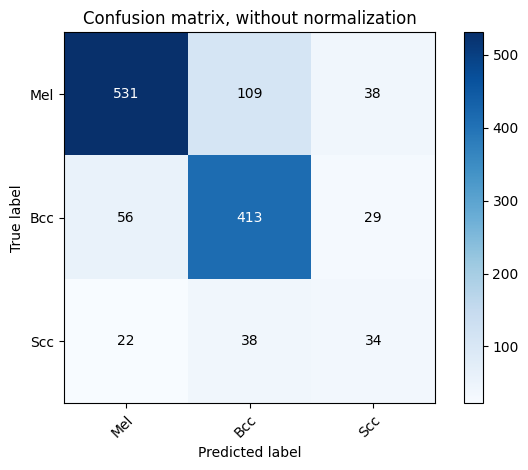

In [ ]:
y_probs = (knn_probs + svm_probs + xgb_probs)/3
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[467,  96, 115],
       [ 50, 312, 136],
       [  9,  19,  66]], dtype=int64), 'accuracy': 0.6653543307086615, 'kappa': 0.467611863156275, 'bma': 0.67247474804761}
Confusion matrix, without normalization
[[467  96 115]
 [ 50 312 136]
 [  9  19  66]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

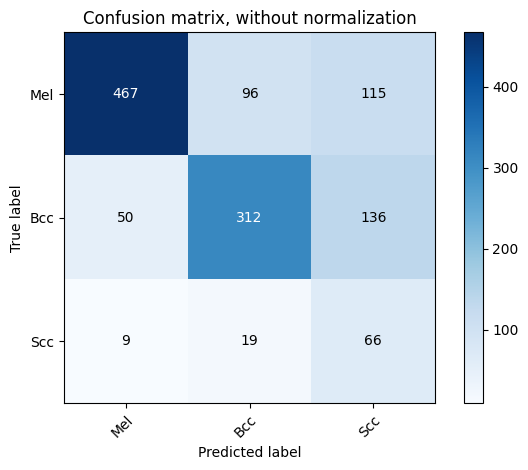

In [ ]:
y_probs = (knn_probs + svm_probs)/2
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

#### Sampled II

In [ ]:
svm_probs = svm_sm2.predict_proba(test_features_all) # bma = 0.64887428960176
xgb_probs = xgbt_sm2.predict_proba(test_features_all) # bma = 0.63055750271531
rf_probs = rf_sm2.predict_proba(test_features_all) # bma =  0.62333902231659
xtree_probs = xtree_sm2.predict_proba(test_features_all) # bma = 0.622322340261
knn_probs = knn_sm2.predict_proba(test_features_all) # bma = 0.571423584251019

{'confusion_matrix': array([[466, 118,  94],
       [ 67, 345,  86],
       [ 17,  23,  54]], dtype=int64), 'accuracy': 0.6811023622047244, 'kappa': 0.47298908989565314, 'bma': 0.6515182678873405}
Confusion matrix, without normalization
[[466 118  94]
 [ 67 345  86]
 [ 17  23  54]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

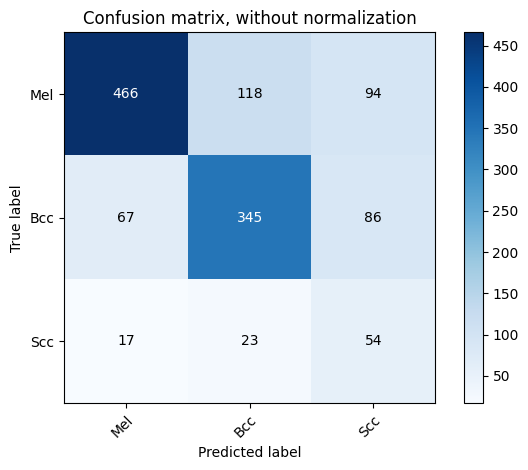

In [ ]:
y_probs = (svm_probs + xgb_probs + rf_probs + xtree_probs + knn_probs)/5
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[480, 118,  80],
       [ 77, 349,  72],
       [ 18,  24,  52]], dtype=int64), 'accuracy': 0.6937007874015748, 'kappa': 0.4850399643093909, 'bma': 0.6539864346610065}
Confusion matrix, without normalization
[[480 118  80]
 [ 77 349  72]
 [ 18  24  52]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

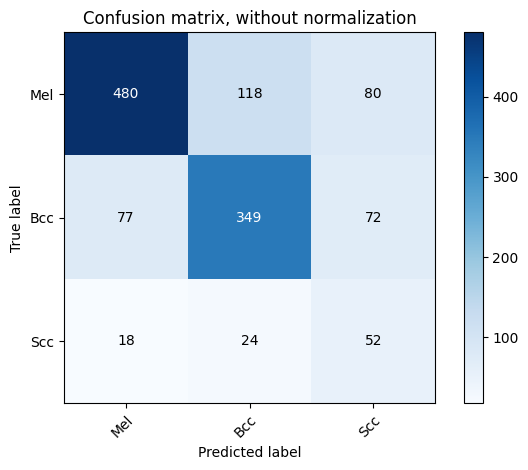

In [ ]:
y_probs = (svm_probs + xgb_probs + rf_probs + xtree_probs)/4
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[482, 115,  81],
       [ 79, 340,  79],
       [ 17,  24,  53]], dtype=int64), 'accuracy': 0.6889763779527559, 'kappa': 0.4787792014562804, 'bma': 0.6524917217353693}
Confusion matrix, without normalization
[[482 115  81]
 [ 79 340  79]
 [ 17  24  53]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

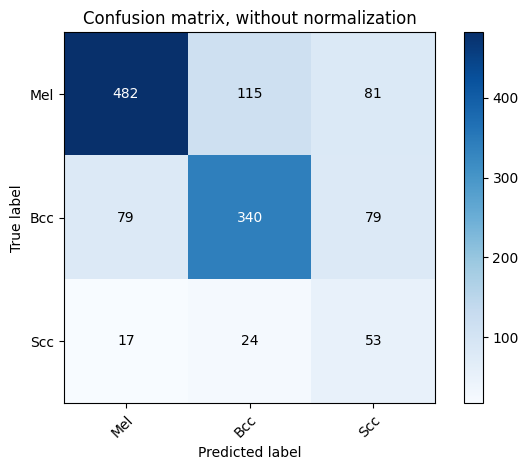

In [ ]:
y_probs = (svm_probs + xgb_probs + rf_probs)/3
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[478, 117,  83],
       [ 78, 338,  82],
       [ 19,  24,  51]], dtype=int64), 'accuracy': 0.6826771653543308, 'kappa': 0.46918909276460175, 'bma': 0.6420942667298831}
Confusion matrix, without normalization
[[478 117  83]
 [ 78 338  82]
 [ 19  24  51]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

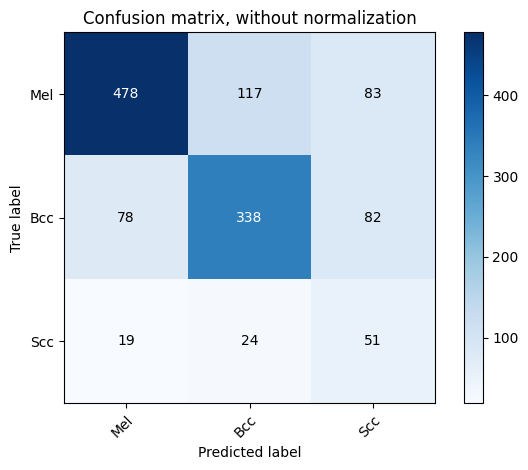

In [ ]:
y_probs = (svm_probs + xgb_probs)/2
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

#### Best

In [ ]:
knn_probs = knn_all.predict_proba(test_features_all) # bma = 0.6611915559
svm_probs = svm_sm2.predict_proba(test_features_all) # bma = 0.64887428960176
xgb_probs = xgbt_sm2.predict_proba(test_features_all) # bma = 0.63055750271531
rf_probs = rf_sm2.predict_proba(test_features_all) # bma =  0.62333902231659
xtree_probs = xtree_sm2.predict_proba(test_features_all) # bma = 0.622322340261

{'confusion_matrix': array([[519, 107,  52],
       [ 76, 371,  51],
       [ 19,  24,  51]], dtype=int64), 'accuracy': 0.7409448818897638, 'kappa': 0.5517499592334165, 'bma': 0.6843399456105977}
Confusion matrix, without normalization
[[519 107  52]
 [ 76 371  51]
 [ 19  24  51]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

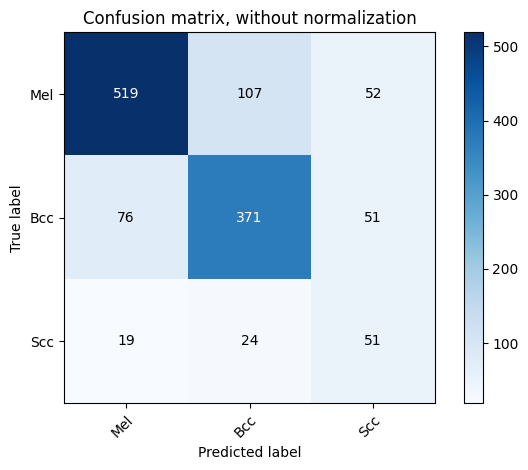

In [ ]:
y_probs = (knn_probs + svm_probs + xgb_probs + rf_probs + xtree_probs)/5
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[523, 103,  52],
       [ 75, 376,  47],
       [ 19,  24,  51]], dtype=int64), 'accuracy': 0.7480314960629921, 'kappa': 0.5630013548678466, 'bma': 0.6896532341630376}
Confusion matrix, without normalization
[[523 103  52]
 [ 75 376  47]
 [ 19  24  51]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

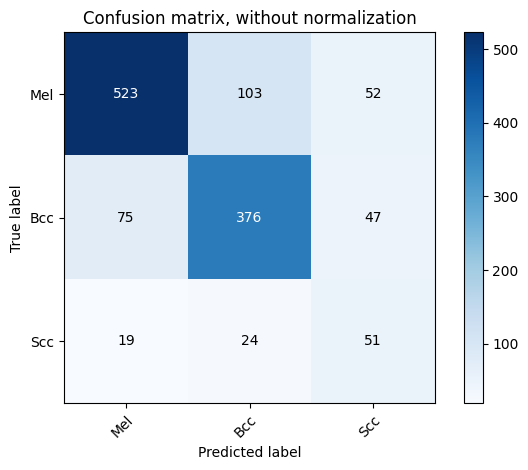

In [ ]:
y_probs = (knn_probs + svm_probs + xgb_probs + rf_probs)/4
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[523, 103,  52],
       [ 75, 379,  44],
       [ 18,  25,  51]], dtype=int64), 'accuracy': 0.7503937007874015, 'kappa': 0.5666172918182718, 'bma': 0.6916612662915517}
Confusion matrix, without normalization
[[523 103  52]
 [ 75 379  44]
 [ 18  25  51]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

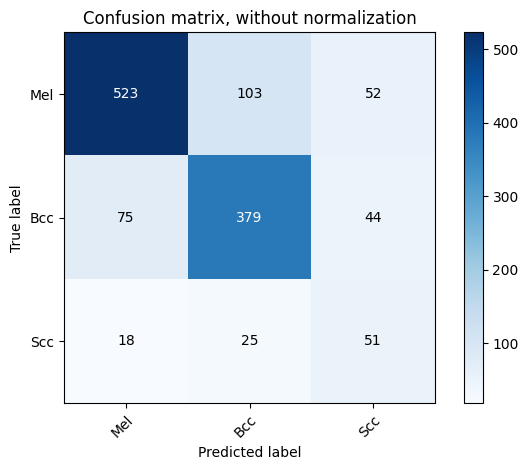

In [ ]:
y_probs = (knn_probs + svm_probs + xgb_probs)/3
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

{'confusion_matrix': array([[522, 119,  37],
       [ 95, 366,  37],
       [ 24,  25,  45]], dtype=int64), 'accuracy': 0.7346456692913386, 'kappa': 0.5312965429027001, 'bma': 0.6611915559054141}
Confusion matrix, without normalization
[[522 119  37]
 [ 95 366  37]
 [ 24  25  45]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

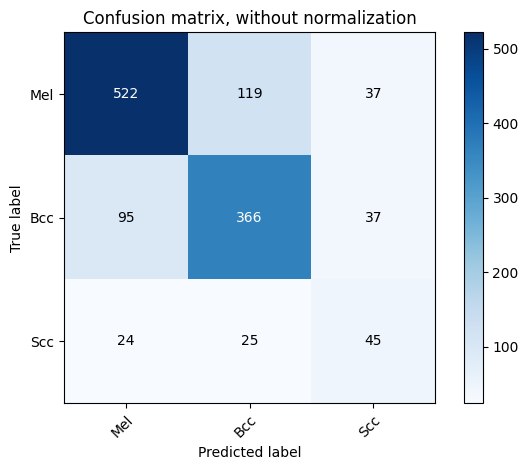

In [ ]:
y_probs = (knn_probs + svm_probs)/2
y_preds = np.argmax(y_probs, axis=1)
scores = validate_mc(y_preds, test_labels_all)
print(scores)
plot_confusion_matrix(test_labels_all, y_preds, ['Mel', 'Bcc', 'Scc'])

### Saving models

In [ ]:
# ALL 
with open(os.path.join('models', 'knn_all_all' + '.pkl'), 'wb') as f:
        pickle.dump(knn_all, f)
print("Model saved..\n")

with open(os.path.join('models', 'svm_all_all' + '.pkl'), 'wb') as f:
        pickle.dump(svm_all, f)
print("Model saved..\n")

with open(os.path.join('models', 'rf_all_all' + '.pkl'), 'wb') as f:
        pickle.dump(rf_all, f)
print("Model saved..\n")

with open(os.path.join('models', 'xtree_all_all' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_all, f)
print("Model saved..\n")

with open(os.path.join('models', 'xgbt_all_all' + '.pkl'), 'wb') as f:
        pickle.dump(xgbt_all, f)
print("Model saved..\n")

Model saved..

Model saved..

Model saved..

Model saved..

Model saved..



In [ ]:
# Sampled I
with open(os.path.join('models', 'knn_all_sm1' + '.pkl'), 'wb') as f:
        pickle.dump(knn_sm1, f)
print("Model saved..\n")

with open(os.path.join('models', 'svm_all_sm1' + '.pkl'), 'wb') as f:
        pickle.dump(svm_sm1, f)
print("Model saved..\n")

with open(os.path.join('models', 'rf_all_sm1' + '.pkl'), 'wb') as f:
        pickle.dump(rf_sm1, f)
print("Model saved..\n")

with open(os.path.join('models', 'xtree_all_sm1' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_sm1, f)
print("Model saved..\n")

with open(os.path.join('models', 'xgbt_all_sm1' + '.pkl'), 'wb') as f:
        pickle.dump(xgbt_sm1, f)
print("Model saved..\n")

Model saved..

Model saved..

Model saved..

Model saved..

Model saved..



In [ ]:
# Sampled II
with open(os.path.join('models', 'knn_all_sm2' + '.pkl'), 'wb') as f:
        pickle.dump(knn_sm2, f)
print("Model saved..\n")

with open(os.path.join('models', 'svm_all_sm2' + '.pkl'), 'wb') as f:
        pickle.dump(svm_sm2, f)
print("Model saved..\n")

with open(os.path.join('models', 'rf_all_sm2' + '.pkl'), 'wb') as f:
        pickle.dump(rf_sm2, f)
print("Model saved..\n")

with open(os.path.join('models', 'xtree_all_sm2' + '.pkl'), 'wb') as f:
        pickle.dump(xtree_sm2, f)
print("Model saved..\n")

with open(os.path.join('models', 'xgbt_all_sm2' + '.pkl'), 'wb') as f:
        pickle.dump(xgbt_sm2, f)
print("Model saved..\n")

Model saved..

Model saved..

Model saved..

Model saved..

Model saved..

